TO DO:
- resolve staggered structure
- resolve branch of P3 and difference of P3 and P3Alt
- resolve boundary condition when moving to around z=0
- resolve the periodicity issue in TT

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp
import scipy.linalg
import scipy.optimize
# import scipy.special

from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

In [2]:
psipsi00 = np.loadtxt("../data/m0.000000Lx384Ly384alat0.010000ortho0psipsi00.dat")
psipsi01 = np.loadtxt("../data/m0.000000Lx384Ly384alat0.010000ortho0psipsi01.dat")
psipsi10 = np.loadtxt("../data/m0.000000Lx384Ly384alat0.010000ortho0psipsi10.dat")
psipsi11 = np.loadtxt("../data/m0.000000Lx384Ly384alat0.010000ortho0psipsi11.dat")

In [2]:
psipsi00 = np.loadtxt("../data/m0.000000Lx768Ly768alat0.010000ortho0psipsi00.dat")
psipsi01 = np.loadtxt("../data/m0.000000Lx768Ly768alat0.010000ortho0psipsi01.dat")
psipsi10 = np.loadtxt("../data/m0.000000Lx768Ly768alat0.010000ortho0psipsi10.dat")
psipsi11 = np.loadtxt("../data/m0.000000Lx768Ly768alat0.010000ortho0psipsi11.dat")

In [65]:
768*2

1536

In [66]:
psipsi00 = np.loadtxt("../data/m0.000000Lx1536Ly1536alat0.010000ortho0psipsi00.dat")
psipsi01 = np.loadtxt("../data/m0.000000Lx1536Ly1536alat0.010000ortho0psipsi01.dat")
psipsi10 = np.loadtxt("../data/m0.000000Lx1536Ly1536alat0.010000ortho0psipsi10.dat")
psipsi11 = np.loadtxt("../data/m0.000000Lx1536Ly1536alat0.010000ortho0psipsi11.dat")

In [3]:
alat = 0.01

Lx = 768 # 384 # 768 # 1536
Ly = Lx

m = 0.0

tau = np.exp( 1.0j*np.pi/3 )

Lu = Lx
Lv = np.sqrt(3)*0.5*Ly

In [4]:
def theta(z, n=0, nmax=1e5, tol=1.0e-15):
    r = np.pi*1.0j/tau
    arr = np.full(n+1, 0)
    arr[n]=1
    Hn = np.polynomial.hermite.Hermite( arr )

    coeff = Hn( np.sqrt(r)*z )
    exp = np.exp( -r*z**2 )
    s = coeff * exp

    s_old = s
    for ell in np.arange(1,nmax):
        coeff = Hn( np.sqrt(r)*(ell+z) )
        exp = np.exp( -r*(ell+z)**2 )
        s += coeff * exp

        coeff = Hn( np.sqrt(r)*(-ell+z) )
        exp = np.exp( -r*(-ell+z)**2 )
        s += coeff * exp
        
        if np.abs(s-s_old)<tol: break
        s_old = s
        if ell==nmax-1: 
            print("did not converge for z = ", z)
            return np.nan
            assert(False)

    coeff = (-1)**n * r**(n/2) / np.sqrt(-1.0j*tau)
        
    return coeff * s

In [74]:
def th1(z, n=0):
    s = 0.0
    for k in np.arange(n+1):
        A = (np.pi*1.0j)**k
        B = theta( z+0.5*tau+0.5, n-k )
        binomial = scipy.special.comb(n,k)
        s += binomial * A * B

    im = 0.25*np.pi*tau + np.pi*(z+0.5)
    coeff = np.exp( 1.0j*im )

    return -coeff * s


def th2(z, n=0):
    s = 0.0
    for k in np.arange(n+1):
        A = (np.pi*1.0j)**k
        B = theta( z+0.5*tau, n-k )
        binomial = scipy.special.comb(n,k)
        s += binomial * A * B

    im = 0.25*np.pi*tau + np.pi*(z)
    coeff = np.exp( 1.0j*im )

    return -coeff * s

def th3(z, n=0):
    return theta(z, n)

def th4(z, n=0):
    return theta(z+0.5, n)

In [82]:
zz =0.2 + 1.0j*0.6
print( th4(zz+1)-th4(zz) )
print( th4(zz+tau) + np.exp(-2.0*np.pi*1.0j*zz - np.pi*1.0j*tau) * th4(zz) )

print( th1(zz+1)+th1(zz) )
print( th1(zz+tau) + np.exp(-2.0*np.pi*1.0j*zz - np.pi*1.0j*tau) * th1(zz) )

print( th2(zz+1)+th2(zz) )
print( th2(zz+tau) - np.exp(-2.0*np.pi*1.0j*zz - np.pi*1.0j*tau) * th2(zz) )

0j
(2.5011104298755527e-12+2.2737367544323206e-12j)
(3.552713678800501e-15-4.440892098500626e-16j)
(-2.7284841053187847e-12-7.73070496506989e-12j)
(4.884981308350689e-15+3.9968028886505635e-15j)
(-5.4569682106375694e-12-1.1368683772161603e-13j)


In [63]:
th1p0 = th1(0, 1)
th20 = th2(0)
th30 = th3(0)
th40 = th4(0)

In [90]:
e1 = 1.0/3.0 * (np.pi)**2 * (th30**4 + th40**4)
e2 = 1.0/3.0 * (np.pi)**2 * (th20**4 - th40**4)
e3 = -1.0/3.0 * (np.pi)**2 * (th20**4 + th30**4)

In [117]:
def P(z):
    res = 0.0
    
    tmp = np.pi * th20*th30*th4(z)/th1(z)
    res += tmp**2
    
    tmp = th20**4 + th30**4
    tmp *= np.pi**2/3.0
    res -= tmp
    
    return res

In [123]:
def P1Alt(z):
    return np.sqrt( P(z)-e1 )
def P2Alt(z):
    return np.sqrt( P(z)-e2 )
def P3Alt(z):
    return np.sqrt( P(z)-e2 )

In [124]:
def P3(z):
    return th1p0/th30 * th3(z)/th1(z)

In [126]:
P3Alt(0.2+0.2j)

(3.208168833442762-2.744228875695544j)

In [127]:
P3(0.2+0.2j)

(3.2081688334427616-2.7442288756955446j)

In [128]:
tes=np.array([ [elem[0], elem[1], P3(elem[0]+elem[1]*tau)] for elem in res ])

/tmp/ipykernel_182826/2837087437.py:6: RuntimeWarning: invalid value encountered in log
  ax.scatter(tes.T[0], tes.T[1], np.log(np.real(tes.T[2])), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_182826/2837087437.py:7: RuntimeWarning: invalid value encountered in log
  ax.scatter(tes.T[0], tes.T[1], np.log(np.real(-tes.T[2])), c='b', marker='o', label="-", alpha=0.2)


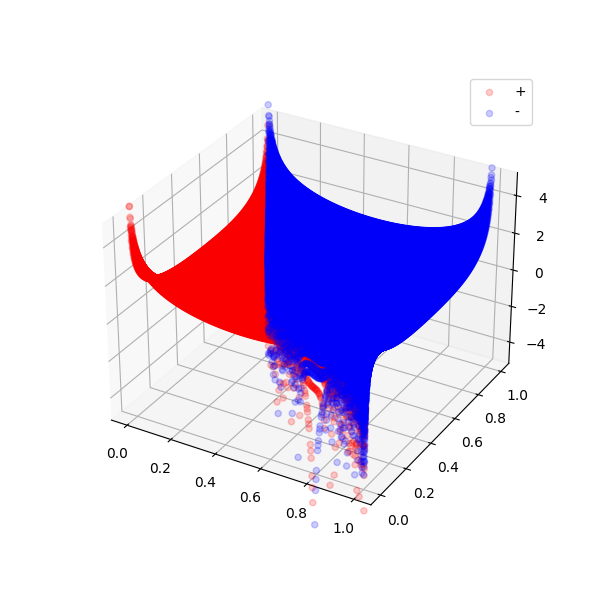

In [129]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tes.T[0], tes.T[1], np.log(np.real(tes.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(tes.T[0], tes.T[1], np.log(np.real(-tes.T[2])), c='b', marker='o', label="-", alpha=0.2)

ax.set_zlim( -5, 5)

plt.legend()

/tmp/ipykernel_182826/1332558539.py:6: RuntimeWarning: invalid value encountered in log
  ax.scatter(tes.T[0], tes.T[1], np.log(np.imag(tes.T[2])), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_182826/1332558539.py:7: RuntimeWarning: invalid value encountered in log
  ax.scatter(tes.T[0], tes.T[1], np.log(np.imag(-tes.T[2])), c='b', marker='o', label="-", alpha=0.2)


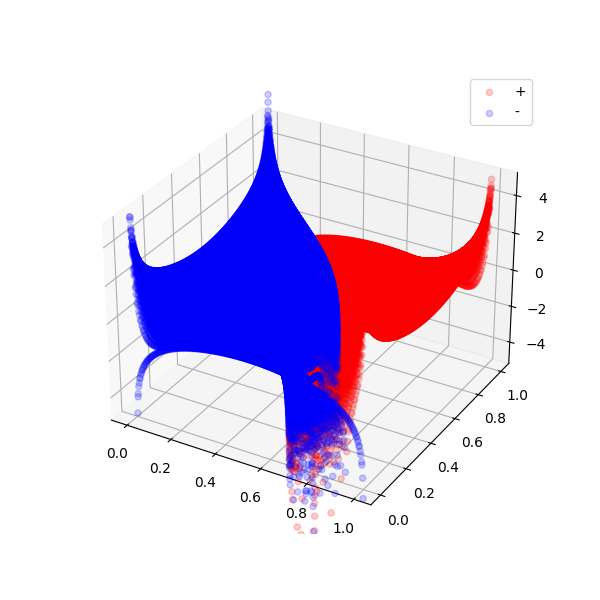

In [130]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tes.T[0], tes.T[1], np.log(np.imag(tes.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(tes.T[0], tes.T[1], np.log(np.imag(-tes.T[2])), c='b', marker='o', label="-", alpha=0.2)

ax.set_zlim( -5, 5)

plt.legend()

In [131]:
Leff = int(Lx/3*2)

tmpx = psipsi01.T[0]
tmpy = psipsi01.T[1]
tmpzr = psipsi01.T[2]
tmpzi = psipsi01.T[3]
res_ = []

alat = 1.0/Lx
factor = (1.0/np.sqrt(2.0*np.pi) * 3.0/2.0 * np.sqrt(alat))**2

for i in range(len(psipsi01.T[0])):
    if (i+1)%3!=0:
        res_.append( [ tmpx[i]/Lx, tmpy[i]/Lx, (tmpzr[i]+1.0j*tmpzi[i])/factor ] )
res = np.array(res_)

/tmp/ipykernel_182826/1466752826.py:7: RuntimeWarning: invalid value encountered in log
  ax.scatter(res.T[0], res.T[1], np.log(np.real(res.T[2])), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_182826/1466752826.py:8: RuntimeWarning: invalid value encountered in log
  ax.scatter(res.T[0], res.T[1], np.log(-np.real(res.T[2])), c='b', marker='o', label="-", alpha=0.2)


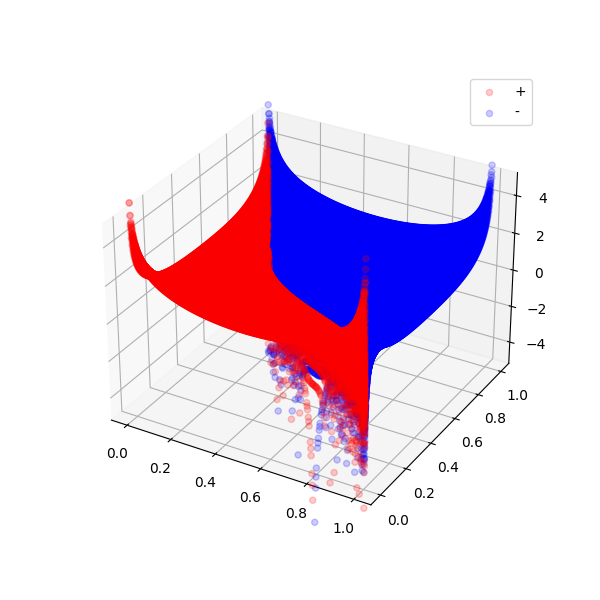

In [132]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(lis00.T[0], lis00.T[1], np.log(np.real(lis00.T[2])), c='b', marker='.', label="pp", alpha=0.1)
ax.scatter(res.T[0], res.T[1], np.log(np.real(res.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(res.T[0], res.T[1], np.log(-np.real(res.T[2])), c='b', marker='o', label="-", alpha=0.2)

ax.set_zlim( -5, 5)

plt.legend()

/tmp/ipykernel_182826/2398484532.py:7: RuntimeWarning: invalid value encountered in log
  ax.scatter(res.T[0], res.T[1], np.log(np.imag(res.T[2])), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_182826/2398484532.py:8: RuntimeWarning: invalid value encountered in log
  ax.scatter(res.T[0], res.T[1], np.log(-np.imag(res.T[2])), c='b', marker='o', label="-", alpha=0.2)


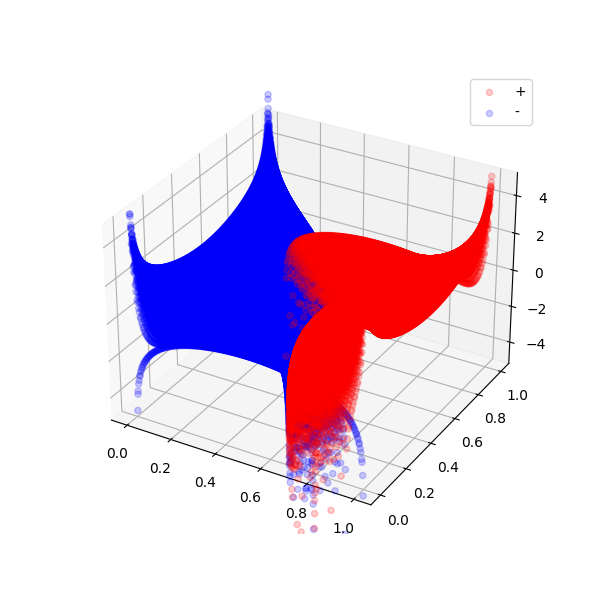

In [133]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(lis00.T[0], lis00.T[1], np.log(np.real(lis00.T[2])), c='b', marker='.', label="pp", alpha=0.1)
ax.scatter(res.T[0], res.T[1], np.log(np.imag(res.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(res.T[0], res.T[1], np.log(-np.imag(res.T[2])), c='b', marker='o', label="-", alpha=0.2)

ax.set_zlim( -5, 5)

plt.legend()

In [134]:
Leff = int(Lx/3*2)

tmpx = psipsi10.T[0]
tmpy = psipsi10.T[1]
tmpzr = psipsi10.T[2]
tmpzi = psipsi10.T[3]
res_ = []

alat = 1.0/Lx
factor = (1.0/np.sqrt(2.0*np.pi) * 3.0/2.0 * np.sqrt(alat))**2

for i in range(len(psipsi01.T[0])):
    if (i+1)%3!=0:
        res_.append( [ tmpx[i]/Lx, tmpy[i]/Lx, (tmpzr[i]+1.0j*tmpzi[i])/factor ] )
res = np.array(res_)

In [ ]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(lis00.T[0], lis00.T[1], np.log(np.real(lis00.T[2])), c='b', marker='.', label="pp", alpha=0.1)
ax.scatter(res.T[0], res.T[1], np.log(np.real(res.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(res.T[0], res.T[1], np.log(-np.real(res.T[2])), c='b', marker='o', label="-", alpha=0.2)

ax.set_zlim( -5, 5)

plt.legend()

/tmp/ipykernel_182826/1466752826.py:7: RuntimeWarning: invalid value encountered in log
  ax.scatter(res.T[0], res.T[1], np.log(np.real(res.T[2])), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_182826/1466752826.py:8: RuntimeWarning: invalid value encountered in log
  ax.scatter(res.T[0], res.T[1], np.log(-np.real(res.T[2])), c='b', marker='o', label="-", alpha=0.2)


In [ ]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(lis00.T[0], lis00.T[1], np.log(np.real(lis00.T[2])), c='b', marker='.', label="pp", alpha=0.1)
ax.scatter(res.T[0], res.T[1], np.log(np.imag(res.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(res.T[0], res.T[1], np.log(-np.imag(res.T[2])), c='b', marker='o', label="-", alpha=0.2)

ax.set_zlim( -5, 5)

plt.legend()

In [56]:
Leff = int(Lx/3*2)

tmpx = psipsi10.T[0]
tmpy = psipsi10.T[1]
tmpzr = psipsi10.T[2]
tmpzi = psipsi10.T[3]
res_ = []

alat = 1.0/Lx
factor = (1.0/np.sqrt(2.0*np.pi) * 3.0/2.0 * np.sqrt(alat))**2

for i in range(len(psipsi01.T[0])):
    if (i+1)%3!=0:
        res_.append( [ tmpx[i]/Lx, tmpy[i]/Lx, (tmpzr[i]+1.0j*tmpzi[i])/factor ] )
res = np.array(res_)

/tmp/ipykernel_182826/1466752826.py:7: RuntimeWarning: invalid value encountered in log
  ax.scatter(res.T[0], res.T[1], np.log(np.real(res.T[2])), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_182826/1466752826.py:8: RuntimeWarning: invalid value encountered in log
  ax.scatter(res.T[0], res.T[1], np.log(-np.real(res.T[2])), c='b', marker='o', label="-", alpha=0.2)


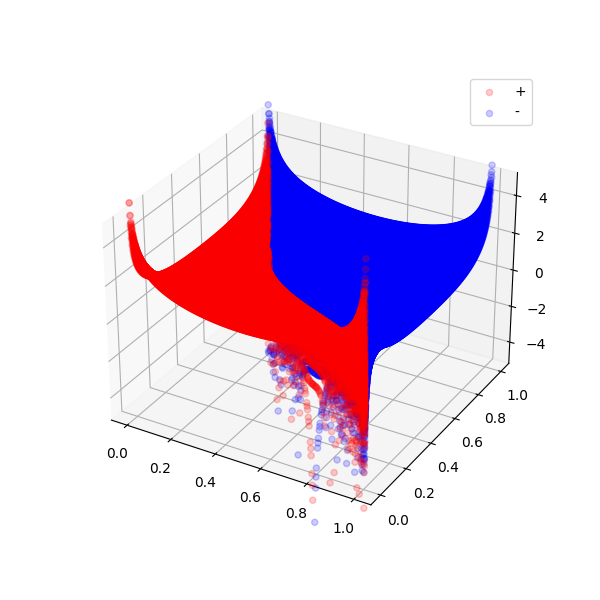

In [57]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(lis00.T[0], lis00.T[1], np.log(np.real(lis00.T[2])), c='b', marker='.', label="pp", alpha=0.1)
ax.scatter(res.T[0], res.T[1], np.log(np.real(res.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(res.T[0], res.T[1], np.log(-np.real(res.T[2])), c='b', marker='o', label="-", alpha=0.2)

ax.set_zlim( -5, 5)

plt.legend()

/tmp/ipykernel_182826/2398484532.py:7: RuntimeWarning: invalid value encountered in log
  ax.scatter(res.T[0], res.T[1], np.log(np.imag(res.T[2])), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_182826/2398484532.py:8: RuntimeWarning: invalid value encountered in log
  ax.scatter(res.T[0], res.T[1], np.log(-np.imag(res.T[2])), c='b', marker='o', label="-", alpha=0.2)


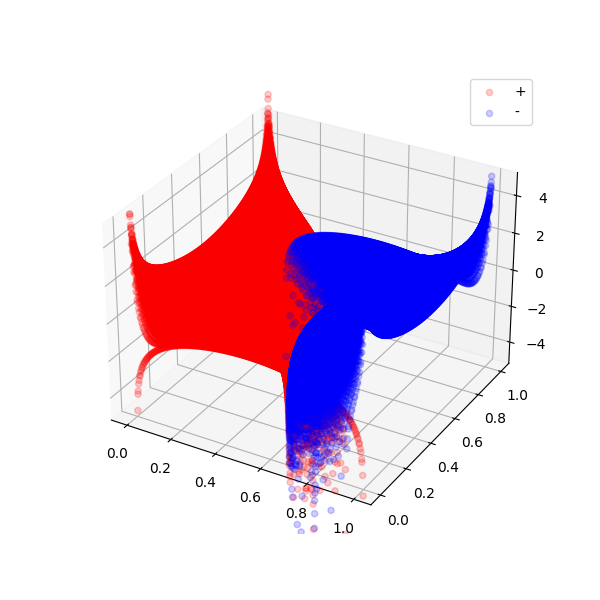

In [58]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(lis00.T[0], lis00.T[1], np.log(np.real(lis00.T[2])), c='b', marker='.', label="pp", alpha=0.1)
ax.scatter(res.T[0], res.T[1], np.log(np.imag(res.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(res.T[0], res.T[1], np.log(-np.imag(res.T[2])), c='b', marker='o', label="-", alpha=0.2)

ax.set_zlim( -5, 5)

plt.legend()

In [30]:
alat = 1.0/Lx

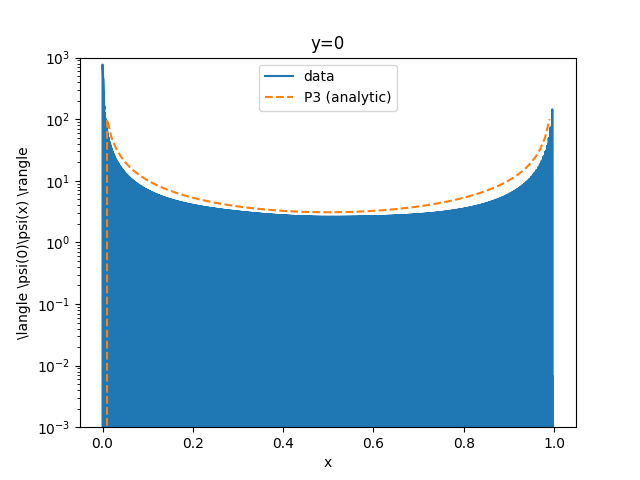

In [31]:
plt.close()

plt.plot( res.T[1], res.T[2], label="data" )

xx = np.arange(0.0, 1.0, 0.01)
y = 0.0/Lu
tes=np.array([ [x, P3(x + y*tau)] for x in xx ])
tmp = tes.flatten()
tes2=np.array(np.split(tmp, tmp.shape[0]/2))

plt.plot( tes.T[0], tes.T[1], ls="dashed", label="P3 (analytic)")

plt.yscale("log")
# plt.xscale("log")
plt.ylim(0.001, 1000.0)

plt.legend()
plt.title("y=0")
plt.xlabel("x")
plt.ylabel("\\langle \\psi(0)\\psi(x) \\rangle")

plt.savefig( "psipsi.pdf", bbox_inches="tight" )

In [32]:
plt.scatter( psipsi00.T[0][:512], psipsi00.T[2][:512] )

In [33]:
plt.plot(-psipsi00.T[2])
plt.yscale("log")

In [20]:
def rearrange(corr):
    tmp = np.array([corr.T[0]+0.5*corr.T[1], np.sqrt(3)*0.5*corr.T[1], corr.T[2]]).T
    
    lispp_=[]
    for elem in tmp:
        if 0<=elem[0]<Lu/2 and 0<=elem[1]<Lv/2:
            lispp_.append( [elem[0], elem[1], elem[2]] )
    lispp = np.array( lispp_ )
    
    lismp_=[]
    for elem in tmp:
        if Lu/2<=elem[0] and 0<=elem[1]<Lv/2:
            lismp_.append( [elem[0]-Lu, elem[1], elem[2]] )
    lismp = np.array( lismp_ )
    
    lispm_=[]
    for elem in tmp:
        if 0<=elem[0]<Lu and Lv/2<=elem[1]<Lv:
            lispm_.append( [elem[0]-Lu/2, elem[1]-Lv, elem[2]] )
    lispm = np.array( lispm_ )
    
    lismm_=[]
    for elem in tmp:
        if Lu<=elem[0] and Lv/2<=elem[1]<Lv:
            lismm_.append( [elem[0]-3*Lu/2, elem[1]-Lv, elem[2]] )
    lismm = np.array( lismm_ )
    
    lis=np.concatenate((lispp, lispm, lismp, lismm), axis=0)
    
    return lis

In [21]:
lis00 = rearrange( psipsi00 )
lis01 = rearrange( psipsi01 )
lis10 = rearrange( psipsi10 )
lis11 = rearrange( psipsi11 )

In [68]:
rcorr = np.array([ [np.sqrt(elem[0]**2+elem[1]**2), elem[2]] for elem in psipsi10])

In [69]:
rcorr.shape

(393216, 2)

/scratch/234520.1.ood/ipykernel_257871/2486278121.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(rcorr.T[0], 1.0/rcorr.T[0])


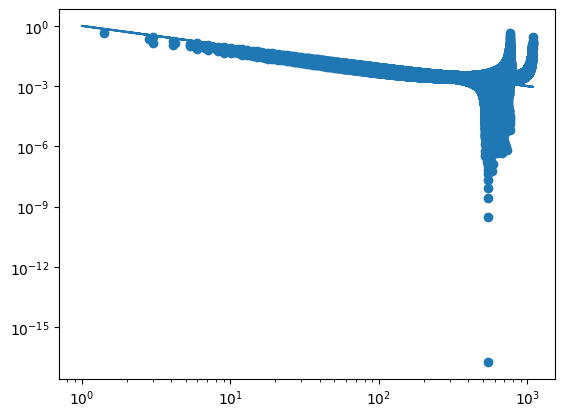

In [70]:
plt.close()
plt.scatter(rcorr.T[0], rcorr.T[1])

plt.plot(rcorr.T[0], 1.0/rcorr.T[0])

plt.yscale("log")
plt.xscale("log")

In [58]:
x=psipsi01.T[0] + 0.5*psipsi01.T[1]
y=0.5*np.sqrt(3.0)*psipsi01.T[1]

In [59]:
x/Lu

array([0.        , 0.00260417, 0.00390625, ..., 1.49414062, 1.49674479,
       1.49804688])

/tmp/ipykernel_47093/2722096613.py:7: RuntimeWarning: invalid value encountered in log
  ax.scatter(x/Lu, y/Lu, np.log(np.real(psipsi01.T[2])), c='r', marker='o', label="pp", alpha=0.2)
/tmp/ipykernel_47093/2722096613.py:8: RuntimeWarning: invalid value encountered in log
  ax.scatter(x/Lu, y/Lu, np.log(np.real(-psipsi01.T[2])), c='b', marker='o', label="pp", alpha=0.2)


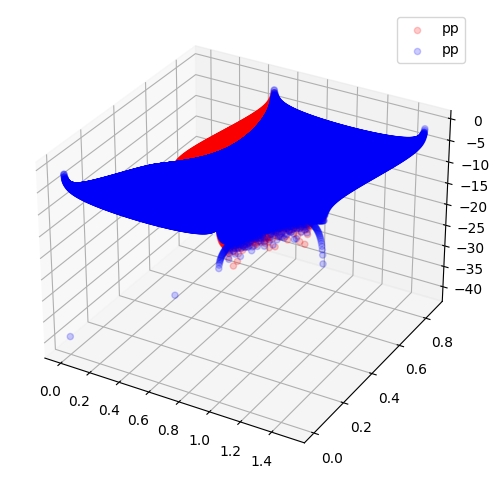

In [62]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(lis00.T[0], lis00.T[1], np.log(np.real(lis00.T[2])), c='b', marker='.', label="pp", alpha=0.1)
ax.scatter(x/Lu, y/Lu, np.log(np.real(psipsi01.T[2])), c='r', marker='o', label="pp", alpha=0.2)
ax.scatter(x/Lu, y/Lu, np.log(np.real(-psipsi01.T[2])), c='b', marker='o', label="pp", alpha=0.2)

# ax.set_zlim( -20, 0)

plt.legend()

In [17]:
z=0.1+0.2*1.0j

In [18]:
P2Alt(z)

(1.6058509877717257-3.413224934386429j)

In [19]:
P2Alt(z-1.0)

(1.6058509877717269-3.4132249343864247j)

In [20]:
P3(z)

(2.6427389586822896-4.006921045082734j)

In [21]:
P3Alt(z)

(2.6427389586822856-4.006921045082738j)

In [22]:
np.conjugate(z)

(0.1-0.2j)

In [23]:
P3(1.0-np.conjugate(z))

(1.6058509877717313+3.4132249343864247j)

In [24]:
P3(z+1.0)

(-2.642738958682287+4.006921045082734j)

In [25]:
P3(z+tau)

(-2.642738958682286+4.006921045082751j)

In [26]:
np.unique(x).shape

(1535,)

In [27]:
Lx/3*2

512.0

In [28]:
psipsi01.T[0][:512]

array([  0.,   2.,   3.,   5.,   6.,   8.,   9.,  11.,  12.,  14.,  15.,
        17.,  18.,  20.,  21.,  23.,  24.,  26.,  27.,  29.,  30.,  32.,
        33.,  35.,  36.,  38.,  39.,  41.,  42.,  44.,  45.,  47.,  48.,
        50.,  51.,  53.,  54.,  56.,  57.,  59.,  60.,  62.,  63.,  65.,
        66.,  68.,  69.,  71.,  72.,  74.,  75.,  77.,  78.,  80.,  81.,
        83.,  84.,  86.,  87.,  89.,  90.,  92.,  93.,  95.,  96.,  98.,
        99., 101., 102., 104., 105., 107., 108., 110., 111., 113., 114.,
       116., 117., 119., 120., 122., 123., 125., 126., 128., 129., 131.,
       132., 134., 135., 137., 138., 140., 141., 143., 144., 146., 147.,
       149., 150., 152., 153., 155., 156., 158., 159., 161., 162., 164.,
       165., 167., 168., 170., 171., 173., 174., 176., 177., 179., 180.,
       182., 183., 185., 186., 188., 189., 191., 192., 194., 195., 197.,
       198., 200., 201., 203., 204., 206., 207., 209., 210., 212., 213.,
       215., 216., 218., 219., 221., 222., 224., 22

In [29]:
Lu

768

In [30]:
psipsi01.T[1]

array([  0.,   0.,   0., ..., 767., 767., 767.])

In [31]:
yy

NameError: name 'yy' is not defined

In [ ]:
P3(1.0 + y/Lu*tau)

In [ ]:
P3Alt(1.0 + y/Lu*tau)

In [ ]:
y=0

In [ ]:
psipsi01.T[2][1+512*y:512*y+512:2]

In [ ]:
psipsi01.T[2][512*y:512*y+512:2]

In [ ]:
psipsi10.T[2][512*y:512*y+512:2]

In [ ]:
psipsi10.T[2][1+512*y:512*y+512:2]

In [ ]:
xx=(psipsi01.T[0][1+512*y:512*y+512:2])/Lu
yy=psipsi01.T[2][1+512*y:512*y+512:2]
plt.plot( xx, yy*1.0e3, label="data, odd" )

xx=(psipsi01.T[0][512*y:512*y+512:2])/Lu
yy=psipsi01.T[2][512*y:512*y+512:2]
plt.plot( xx, yy*1.0e3, label="data, even" )

# plt.yscale("log")
plt.legend()

In [45]:
y=50
x=50

In [59]:
xx=0.4
yy=0.5

print( P3(xx + yy*tau) )
print( P3(xx + 1.0 + yy*tau) )
print( P3(xx + (yy+1.0)*tau) )

print( P3Alt(xx + yy*tau) )
print( P3Alt(xx + 1.0 + yy*tau) )
print( P3Alt(xx + (yy+1.0)*tau) )

(0.5245696483297082-0.8587007392104106j)
(-0.5245696483297084+0.8587007392104131j)
(-0.5245696483297065+0.8587007392104121j)
(0.5245696483297071-0.8587007392104138j)
(0.5245696483297158-0.8587007392104072j)
(0.5245696483297079-0.8587007392103854j)


In [ ]:
x=psipsi01.T[0] + 0.5*psipsi01.T[1]
y=0.5*np.sqrt(3.0)*psipsi01.T[1]

xx=50

tes=np.array([ [yy, P3(xx/Lu + yy*tau)] for yy in np.unique(y)[::10]/Lu ])
tmp = tes.flatten()
tes2=np.array(np.split(tmp, tmp.shape[0]/2))
plt.plot( tes.T[0], tes.T[1], ls="dashed", label="P3")

tes=np.array([ [xx, P3Alt(xx + y/Lu*tau)] for xx in np.unique(x)[::10]/Lu ])
tmp = tes.flatten()
tes2=np.array(np.split(tmp, tmp.shape[0]/2))
plt.plot( tes.T[0], tes.T[1], ls="dotted", label="P3Alt")

plt.legend()

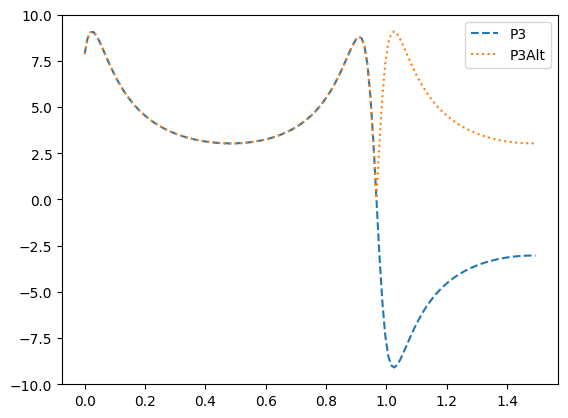

In [50]:
tes=np.array([ [xx, P3(xx + y/Lu*tau)] for xx in np.unique(x)[::10]/Lu ])
tmp = tes.flatten()
tes2=np.array(np.split(tmp, tmp.shape[0]/2))
plt.plot( tes.T[0], tes.T[1], ls="dashed", label="P3")

tes=np.array([ [xx, P3Alt(xx + y/Lu*tau)] for xx in np.unique(x)[::10]/Lu ])
tmp = tes.flatten()
tes2=np.array(np.split(tmp, tmp.shape[0]/2))
plt.plot( tes.T[0], tes.T[1], ls="dotted", label="P3Alt")

plt.legend()

y= 100


/share/pkg.8/python3/3.10.12/install/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


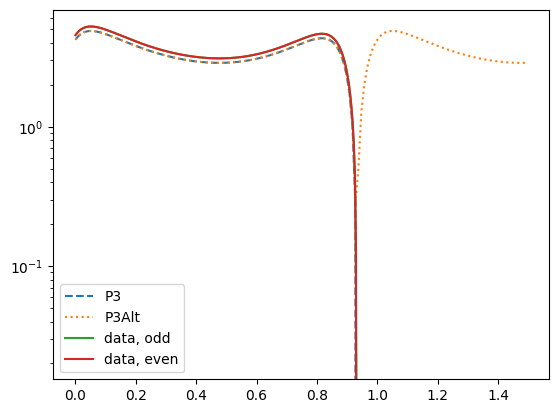

In [32]:
plt.close()

y=100
print("y=",y)

tes=np.array([ [xx, P3(xx + y/Lu*tau)] for xx in np.unique(x)[::10]/Lu ])
tmp = tes.flatten()
tes2=np.array(np.split(tmp, tmp.shape[0]/2))
plt.plot( tes.T[0], tes.T[1], ls="dashed", label="P3")

tes=np.array([ [xx, P3Alt(xx + y/Lu*tau)] for xx in np.unique(x)[::10]/Lu ])
tmp = tes.flatten()
tes2=np.array(np.split(tmp, tmp.shape[0]/2))
plt.plot( tes.T[0], tes.T[1], ls="dotted", label="P3Alt")

xx=(psipsi01.T[0][1+512*y:512*y+512:2])/Lu
yy=psipsi01.T[2][1+512*y:512*y+512:2]
plt.plot( xx, yy*1.0e3, label="data, odd" )

xx=(psipsi01.T[0][512*y:512*y+512:2])/Lu
yy=psipsi01.T[2][512*y:512*y+512:2]
plt.plot( xx, -yy*1.0e3, label="data, even" )

plt.yscale("log")
plt.legend()
# plt.ylim(1e-1, 1e4)

In [194]:
tes=np.array([[ [xx, yy, P3(xx+yy*1.0j)] for xx in np.unique(x)[::10]/Lu ] for yy in np.unique(y)[::10]/Lu ])
tmp = tes.flatten()
tes2=np.array(np.split(tmp, tmp.shape[0]/3))

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_5948/3545635570.py:7: RuntimeWarning: invalid value encountered in log
  ax.scatter(tes2.T[0], tes2.T[1], np.log(np.real(tes2.T[2])), c='r', marker='o', label="P3", alpha=0.1)


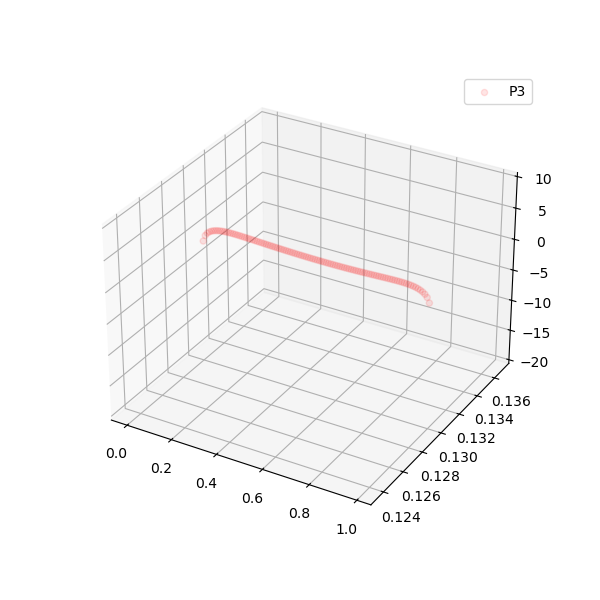

In [195]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(lis00.T[0], lis00.T[1], np.log(np.real(lis00.T[2])), c='b', marker='.', label="pp", alpha=0.1)
ax.scatter(tes2.T[0], tes2.T[1], np.log(np.real(tes2.T[2])), c='r', marker='o', label="P3", alpha=0.1)

# ax.scatter(x/Lu, y/Lu, np.log(np.real(psipsi01.T[2]))+7.0, c='b', marker='x', label="data", alpha=0.2)

ax.set_zlim( -20, 10)

plt.legend()

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_5275/689403235.py:7: RuntimeWarning: invalid value encountered in log
  ax.scatter(lis11.T[0], lis11.T[1], np.log(np.real(lis11.T[2])), c='r', marker='o', label="pp", alpha=0.2)


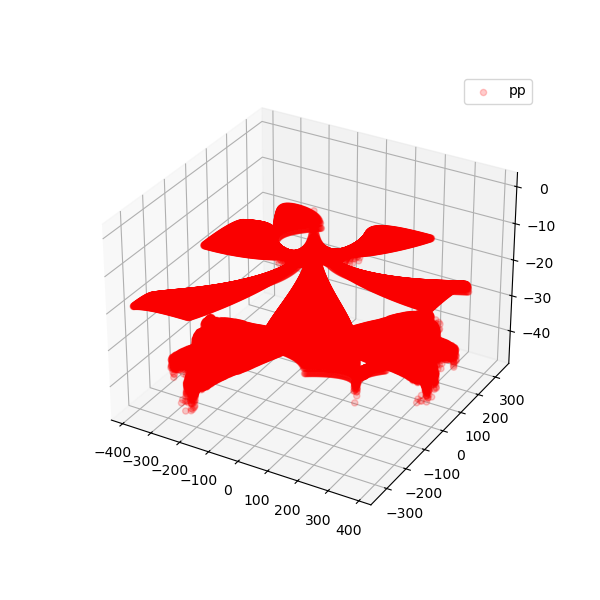

In [72]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(lis00.T[0], lis00.T[1], np.log(np.real(lis00.T[2])), c='b', marker='.', label="pp", alpha=0.1)
ax.scatter(lis11.T[0], lis11.T[1], np.log(np.real(lis11.T[2])), c='r', marker='o', label="pp", alpha=0.2)

# ax.set_zlim( -20, 0)

plt.legend()

In [94]:
tes=np.array([[ [x, y, 1.0/(x+y*1.0j)] for x in np.arange(-0.5, 1.5, 0.01) ] for y in np.arange(-0.5, 1.5, 0.01) ])
tmp = tes.flatten()
tes2=np.array(np.split(tmp, tmp.shape[0]/3))

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_5275/2190234834.py:7: RuntimeWarning: invalid value encountered in log
  ax.scatter(tes2.T[0], tes2.T[1], np.log(np.real(tes2.T[2])), c='r', marker='o', label="pp", alpha=0.2)


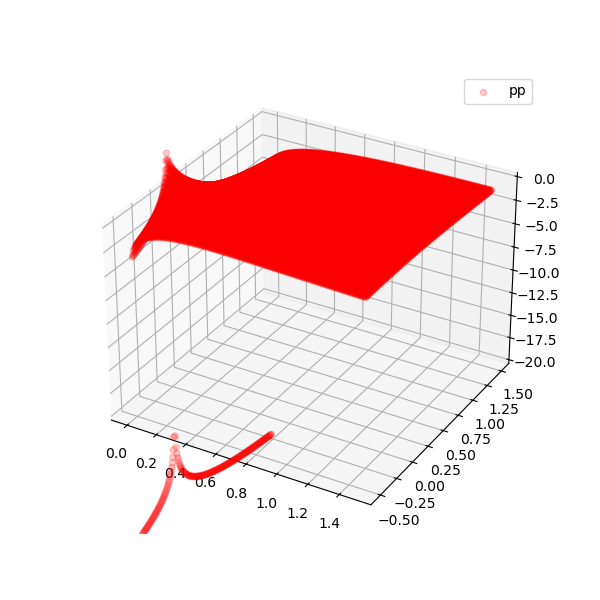

In [95]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(lis00.T[0], lis00.T[1], np.log(np.real(lis00.T[2])), c='b', marker='.', label="pp", alpha=0.1)
ax.scatter(tes2.T[0], tes2.T[1], np.log(np.real(tes2.T[2])), c='r', marker='o', label="pp", alpha=0.2)

ax.set_zlim( -20, 0)

plt.legend()

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_5275/3419919453.py:7: RuntimeWarning: invalid value encountered in log
  ax.scatter(lis01.T[0], lis01.T[1], np.log(np.real(lis01.T[2])), c='r', marker='o', label="pp", alpha=0.2)


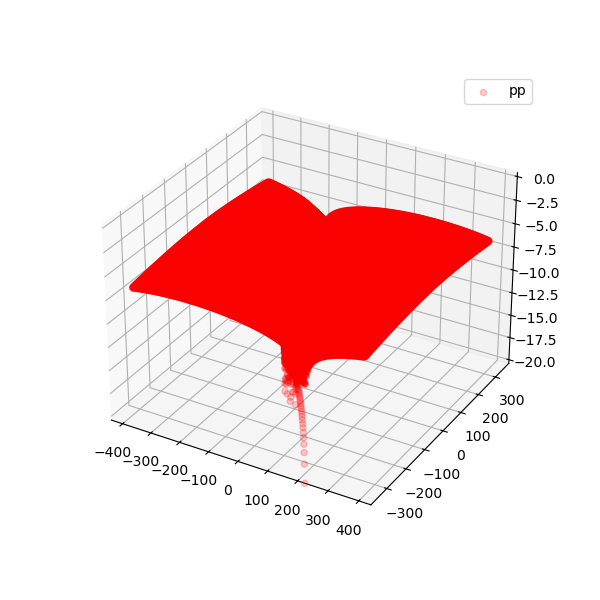

In [41]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(lis00.T[0], lis00.T[1], np.log(np.real(lis00.T[2])), c='b', marker='.', label="pp", alpha=0.1)
ax.scatter(lis01.T[0], lis01.T[1], np.log(np.real(lis01.T[2])), c='r', marker='o', label="pp", alpha=0.2)

ax.set_zlim( -20, 0)

plt.legend()

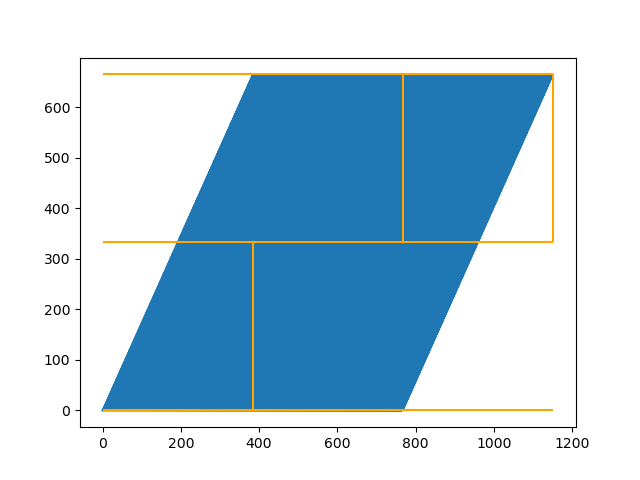

In [14]:
plt.close()
plt.plot(T0T0.T[0], T0T0.T[1])

plt.vlines(Lu/2, 0, Lv/2, color="orange")
plt.vlines(2*Lu/2, Lv/2, Lv, color="orange")
plt.vlines(3*Lu/2, Lv/2, Lv, color="orange")

plt.hlines(0, 0, 3*Lu/2, color="orange")
plt.hlines(Lv/2, 0, 3*Lu/2, color="orange")
plt.hlines(Lv, 0, 3*Lu/2, color="orange")

plt.show()

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_2099/619073122.py:6: RuntimeWarning: invalid value encountered in log
  ax.scatter(lispp.T[0], lispp.T[1], np.log(-lispp.T[2]), c='b', marker='o', label="pp")
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_2099/619073122.py:7: RuntimeWarning: invalid value encountered in log
  ax.scatter(lismp.T[0], lismp.T[1], np.log(-lismp.T[2]), c='g', marker='o', label="pp")
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_2099/619073122.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(lispm.T[0], lispm.T[1], np.log(-lispm.T[2]), c='c', marker='o', label="pm")
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_2099/619073122.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(lismm.T[0], lismm.T[1], np.log(-lismm.T[2]), c='r', marker='o', label="mm")


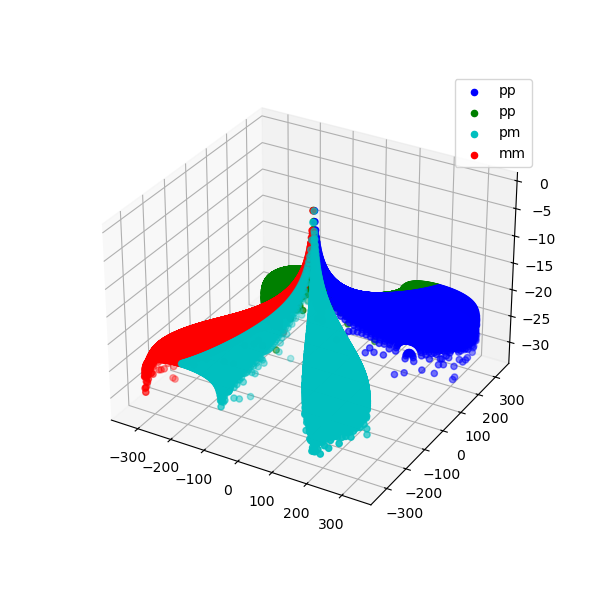

In [19]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(lispp.T[0], lispp.T[1], np.log(-lispp.T[2]), c='b', marker='o', label="pp")
ax.scatter(lismp.T[0], lismp.T[1], np.log(-lismp.T[2]), c='g', marker='o', label="pp")

ax.scatter(lispm.T[0], lispm.T[1], np.log(-lispm.T[2]), c='c', marker='o', label="pm")
ax.scatter(lismm.T[0], lismm.T[1], np.log(-lismm.T[2]), c='r', marker='o', label="mm")
plt.legend()

In [20]:
lis=np.concatenate((lispp, lispm, lismp, lismm), axis=0)

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_2099/2545538510.py:6: RuntimeWarning: invalid value encountered in log
  ax.scatter(lis.T[0], lis.T[1], np.log(lis.T[2]), c='b', marker='o', label="pp")


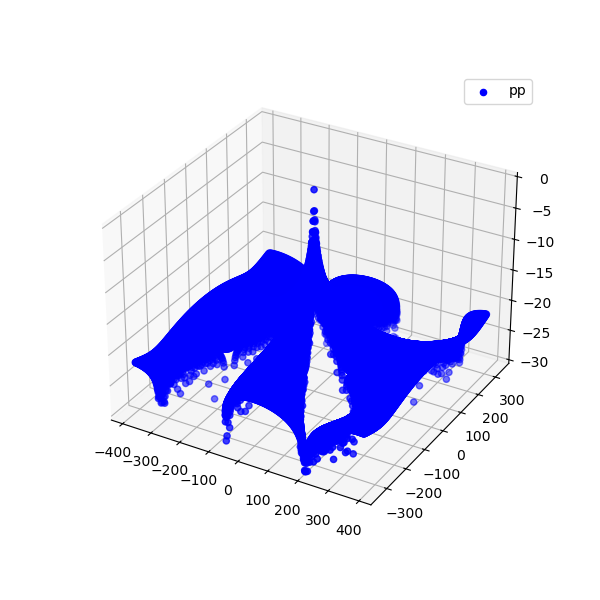

In [21]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(lis.T[0], lis.T[1], np.log(lis.T[2]), c='b', marker='o', label="pp")

ax.set_zlim( -30, 0)

plt.legend()

$
\theta_\nu(z) = \theta_\nu(z,\tau)
$

$\tau$: modular parameter

$\nu=1$: ABC Below (3.3)

Eq.4.2
$
P_\nu(z) =
{\theta_1'(0)\over \theta_\nu(0)}
\cdot
{\theta_\nu(z)\over \theta_1(z)}
$

<!-- $
\langle T(z)T(w)\rangle_{\nu,c} =
\frac{1}{12} c P''(z-w) 
+ 
2(P(z-w)+2\eta_1)\langle T \rangle_\nu
+
2i \pi \partial_\tau \langle T \rangle_\nu
$ -->

Eq.4.3
$
\langle T(z)T(w)\rangle_{\nu,c} =
-\frac{1}{4} 
(
P_\nu'^2 
-
P_\nu'' P_\nu
)
$

In [50]:
np.arange(0, 1.0,0.01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [51]:
tes=np.array([[ [x,y,P(x+y*1.0j)] for x in np.arange(0, 1.0, 0.05) ] for y in np.arange(0, 1.0, 0.05) ])
tmp = tes.flatten()
tes2=np.array(np.split(tmp, tmp.shape[0]/3))

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


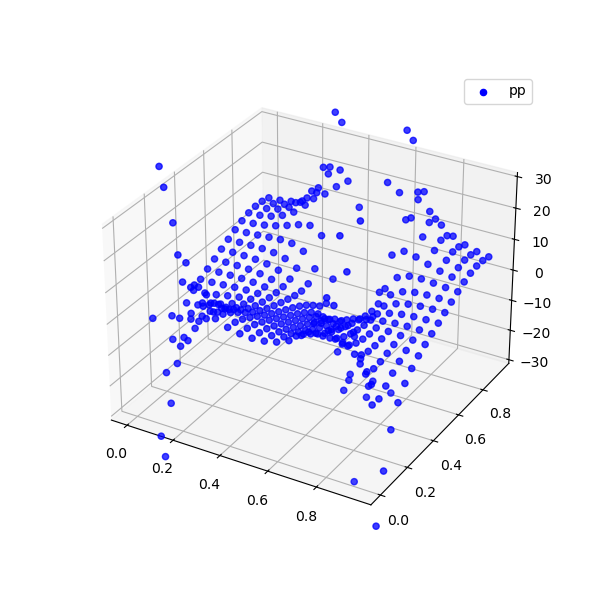

In [52]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tes2.T[0], tes2.T[1], np.real(tes2.T[2]), c='b', marker='o', label="pp")

ax.set_zlim( -30, 30)

plt.legend()

In [80]:
xx=0.2
yy=0.1
P(xx+yy*1.0j)

(11.979477824040625-15.929664214709264j)

In [81]:
P(xx+1.0+yy*1.0j)

(11.979477824040622-15.929664214709268j)

In [82]:
P(xx+1.0+yy*1.0j+tau)

(11.979477824040664-15.929664214709248j)

In [53]:
def dP3(z, tau):
    coeff = th1(0, tau, 1)/th3(0, tau)
    diff1 = th3(z, tau, 1)/th1(z, tau)
    diff2 = - th3(z, tau)/th1(z, tau)**2 * th1(z,tau,1)
    return coeff * (diff1 + diff2)

In [54]:
def ddP3(z, tau):
    coeff = th1(0, tau, 1)/th3(0, tau)
    diff1 = th3(z, tau, 2)/th1(z, tau)
    diff2 = - 2.0 * th3(z, tau, 1)/th1(z, tau)**2 * th1(z,tau,1)
    diff3 = 2.0 * th3(z, tau)/th1(z, tau)**3 * th1(z,tau,1)**2
    diff4 = - th3(z, tau)/th1(z, tau)**2 * th1(z,tau,2)
    return coeff * (diff1 + diff2 + diff3 + diff4)

In [55]:
def TT3( z, tau ):
    coeff = -0.25
    
    P = P3(z, tau)
    dP = dP3(z, tau)
    ddP = ddP3(z, tau)
    
    return coeff * (dP**2 - ddP*P)

In [56]:
e2 = P(tau/2, tau) / (8.0*np.pi)

In [57]:
1.0/12.0 * ( 3.0*th3(0.0, tau, 2)/th3(0.0, tau)- th1(0.0, tau, 3)/th1(0.0, tau, 1) )

(0.7372929961856004-1.2770289294581385j)

In [58]:
e2

(-0.11734382484997154-0.2032454665946146j)

In [59]:
def TFran( z, tau ):
    return -0.25 * e2

In [60]:
ddP(0.1, tau)

(60003.5178785119+1.9995502291276794e-10j)

In [61]:
def TT3Franleading( z, tau ):
    tmp0 = 1.0/24.0 * ddP(z, tau)
    
    return tmp0

In [64]:
# listz = 2.0*np.pi* (T0T0.T[0][::16]/Lx + 1.0j* T0T0.T[1][::16]/Ly)
# # (lis.T[0][::16]/Lu + 1.0j*lis.T[1][::16]/Lv)

In [65]:
# plt.close()
# plt.scatter(np.real( listz ), np.imag( listz ) )

In [66]:
tau = np.exp( np.pi/3.0 * 1.0j )

In [67]:
rmax = 1.0
dr=100

listx_near0 = np.linspace(-rmax, rmax, dr)
listy_near0 = np.linspace(-rmax, rmax, dr)

listz2d_near0 = np.outer( listx_near0, listy_near0 )
listz_near0=np.array([[x+1.0j*y 
                       for x in np.linspace(-rmax, rmax, dr)] 
                      for y in np.linspace(-rmax, rmax, dr) ]).flatten()

# plt.close()
# plt.scatter(np.real( listz_near0 ), np.imag( listz_near0 ) )

In [68]:
e3 = -2.01432 - 3.48891*1.0j

In [69]:
# listP3 = np.array([[z, P3(z, tau)] for z in listz_near0])
# listAsymp1 = np.array([[z, 1.0/z ] for z in listz_near0])
# listAsymp2 = np.array([[z, 1.0/z - 0.5*e3*z ] for z in listz_near0])

In [70]:
# plt.close()

# fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(np.real( listP3.T[0] ), 
#            np.imag( listP3.T[0] ), 
#            np.real(np.log( listP3.T[1] )),
#            c='b', marker='o', label="pp")

# ax.scatter(np.real( listAsymp1.T[0] ), 
#            np.imag( listAsymp1.T[0] ), 
#            np.real(np.log( listAsymp1.T[1] )),
#            c='orange', marker='o', label="asymp1", alpha=0.1)

# ax.scatter(np.real( listAsymp2.T[0] ), 
#            np.imag( listAsymp2.T[0] ), 
#            np.real(np.log( listAsymp2.T[1] )),
#            c='green', marker='o', label="asymp2", alpha=0.1)

# plt.legend()

In [71]:
# listTT = np.array([[z, TT3(z, tau)] for z in listz_near0])
listTTsub = np.array([[z, TT3Franleading(z, tau)] for z in listz_near0])

listTTcont = np.array([[z, 1.0/z**4] for z in listz_near0])

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_1799/621685157.py:8: RuntimeWarning: invalid value encountered in log
  np.log( np.real(listTTsub.T[1]) ) - 20.0,
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_1799/621685157.py:27: RuntimeWarning: invalid value encountered in log
  ax.scatter(lis.T[0]/Lu, lis.T[1]/Lu, np.log(lis.T[2]),


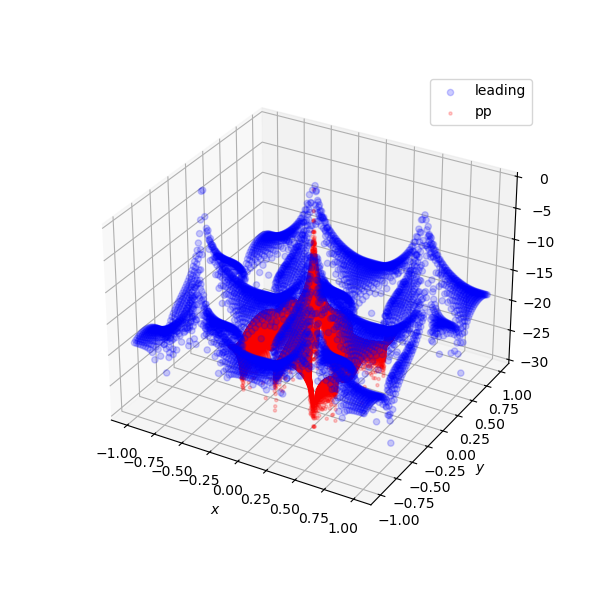

In [74]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.real( listTTsub.T[0] ), 
           np.imag( listTTsub.T[0] ), 
           np.log( np.real(listTTsub.T[1]) ) - 20.0,
           c='b', marker='o', label="leading",
           alpha=0.2)

# ax.scatter(np.real( listTTsub.T[0] ), 
#            np.imag( listTTsub.T[0] ), 
#            np.log( np.real(listTTcont.T[1]) ),
#            c='r', marker='o', label="cont")

# ax.scatter(np.real( listAsymp1.T[0] ), 
#            np.imag( listAsymp1.T[0] ), 
#            np.real(np.log( listAsymp1.T[1] )),
#            c='orange', marker='o', label="asymp1", alpha=0.1)

# ax.scatter(np.real( listAsymp2.T[0] ), 
#            np.imag( listAsymp2.T[0] ), 
#            np.real(np.log( listAsymp2.T[1] )),
#            c='green', marker='o', label="asymp2", alpha=0.1)

ax.scatter(lis.T[0]/Lu, lis.T[1]/Lu, np.log(lis.T[2]), 
           c='red', marker='.', label="pp",
           alpha=0.2)

ax.set_zlim( -30, 0)
ax.set_xlabel( "$x$" )
ax.set_ylabel( "$y$" )

plt.legend()

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_2987/3226224495.py:6: RuntimeWarning: invalid value encountered in log
  ax.scatter(lis.T[0], lis.T[1], np.log(lis.T[2]), c='b', marker='o', label="pp")


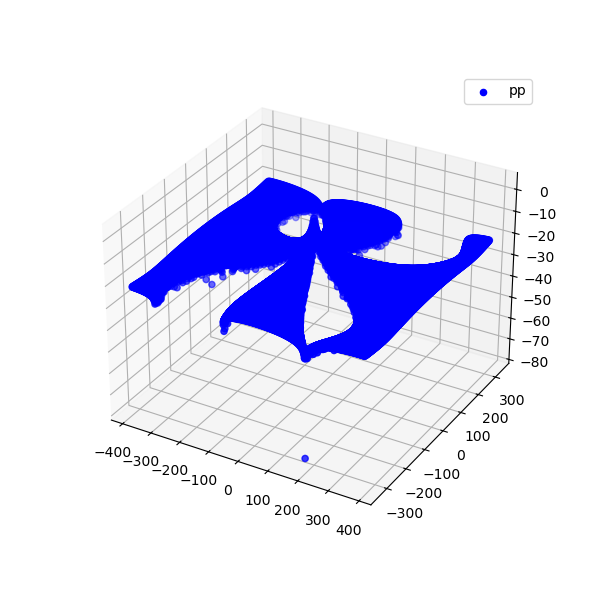

In [118]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(lis.T[0], lis.T[1], np.log(lis.T[2]), c='b', marker='o', label="pp")
plt.legend()

In [66]:
plt.close()

# plt.scatter( np.abs(listP3.T[0]), np.abs( listP3.T[1] ), label="P3" )
# plt.scatter( np.abs(listAsymp.T[0]), np.abs( listAsymp.T[1] ), label="asymp" )
plt.scatter( np.abs(listAsymp.T[0]), np.abs( listP3.T[1]-listAsymp.T[1] ) / np.abs( listP3.T[1] ), label="asymp" )

plt.ylim(0, 10)
plt.legend()

NameError: name 'listAsymp' is not defined

(0.0, 1020.0)

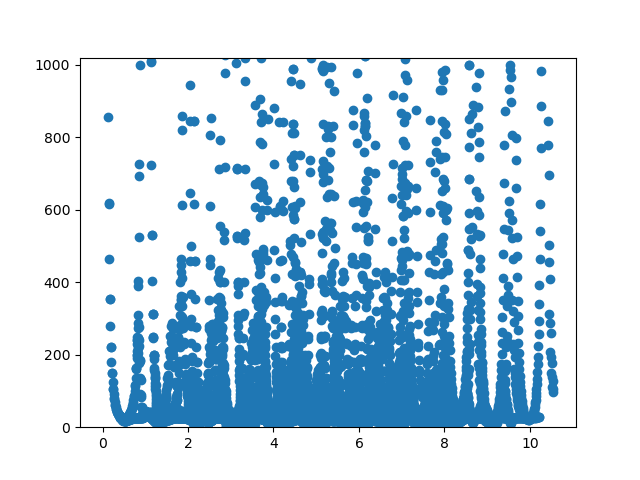

In [155]:
plt.close()

plt.scatter( np.abs(listTT.T[0]), np.abs( listTT.T[1] ) )
plt.ylim(0, 1020)

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_14681/3860897618.py:8: RuntimeWarning: invalid value encountered in log
  np.log( np.real(listTT) ),


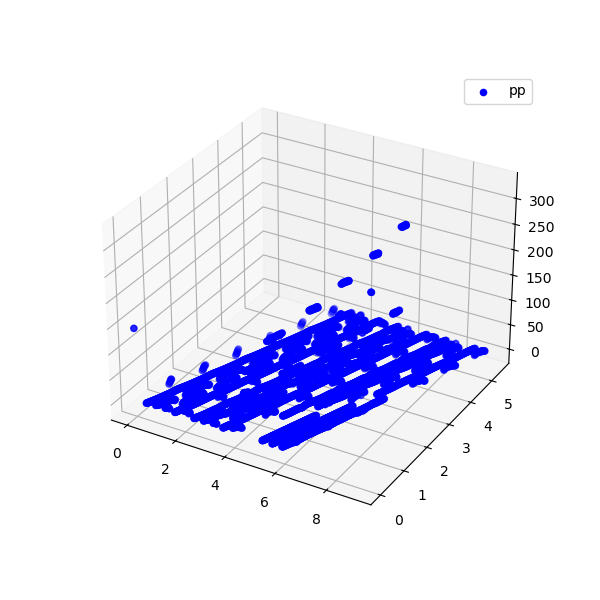

In [147]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.real( listz ), 
           np.imag( listz ), 
           np.log( np.real(listTT) ),
           c='b', marker='o', label="pp")
plt.legend()

In [95]:
z = 9.75+14.289419162443236j

In [97]:
theta(z+0.5*tau+0.5, tau + 2.0j )

(1.88035584167909e+100-1.2910611318483688e+103j)

In [60]:
get_tau(0.5j)

(0.5+0.2206356001526516j)

In [62]:
th1(-1.5, 0.1j)

(3.1622776601682347+3.8726732145402104e-16j)

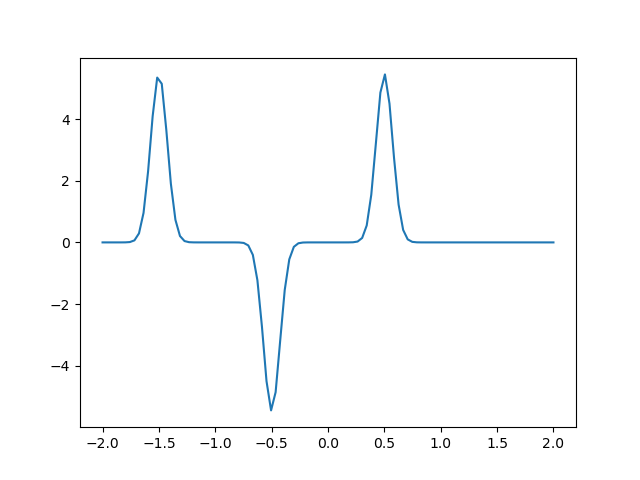

In [86]:
z = np.linspace(-2, 2, 100)
y = [th1(zz, 0.9) for zz in z]

plt.close()
plt.plot(z,y)

In [67]:
th1(-2.0, 0.9)

(-1.7892158556259047e-16+0.9740037464252967j)
(2.144499127241221e-25+1.6344021014743838e-91j)


(3.8369718408359076e-41-2.0887501841387287e-25j)

In [ ]:
def th2(z, nmax=1e4, tol=1.0e-14):

    s = 0.0
    s_old = s
    for n in np.arange(nmax):
        s += (-1.0)**n + q**(n**2+n) * np.sin( (2.0*n+1)*z )
        if np.abs(s-s_old)<tol: break
        s_old = s
        # if n==nmax-1: assert(false); print("no converge")
    
    return 2.0*q**(1/4) * s # mp.jtheta(nu, z, q, derivative=0) # sp.special.elliptic_theta(z, tau, nu=1)


In [25]:
q

(4.0308466239224275e-18+0.06582872101129664j)

In [26]:
th(1.0)

(0.7869962207697958+0.3259845081792199j)

In [33]:
def dth(z, nu=1):
    return mp.jtheta(nu, z, q, derivative=1) # sp.special.elliptic_theta(z, tau)

def ddth(z, nu=1):
    return mp.jtheta(nu, z, q, derivative=2) # sp.special.elliptic_theta(z, tau)

def dddth(z, nu=1):
    return mp.jtheta(nu, z, q, derivative=3) # sp.special.elliptic_theta(z, tau)

In [47]:
mp.dps = 15
mp.pretty = True

In [48]:
mp.re(P(1.0))

mpf('7.5157569530275441e+18')

In [31]:
z=lis.T[0]+1.0j*lis.T[1]
tmp=[P(zz) for zz in z[:100] ]

In [59]:
tmp = tt0000 - 0.5*(tt0001+tt0002) - 0.5*(tt0100+tt0200) + 0.25*(tt0101+tt0102+tt0201+tt0202)
T0T0 = np.array([tt0000.T[0], tt0000.T[1], tmp.T[2]]).T

NameError: name 'tt0000' is not defined

In [11]:
lispp_=[]
for elem in T0T0:
    if 0<=elem[0]<Lx/2 and 0<=elem[1]<Ly/2:
        lispp_.append( [elem[0], elem[1], elem[2]] )
lispp = np.array( lispp_ )

In [12]:
lispm_=[]
for elem in T0T0:
    if 0<=elem[0]<Lx/2 and Ly/2<=elem[1]<Ly:
        lispm_.append( [elem[0], elem[1]-Ly, elem[2]] )
lispm = np.array( lispm_ )

In [13]:
lismp_=[]
for elem in T0T0:
    if Lx/2<=elem[0]<Lx and 0<=elem[1]<Ly/2:
        lismp_.append( [elem[0]-Lx, elem[1], elem[2]] )
lismp = np.array( lismp_ )

In [14]:
lismm_=[]
for elem in T0T0:
    if Lx/2<=elem[0]<Lx and Ly/2<=elem[1]<Ly:
        lismm_.append( [elem[0]-Lx, elem[1]-Ly, elem[2]] )
lismm = np.array( lismm_ )

In [15]:
lisppn_=[]
for elem in lispp:
    lisppn_.append( [elem[0]+0.5*elem[1], np.sqrt(3)*0.5*elem[1], elem[2]] )
lisppn = np.array( lisppn_ )

In [16]:
lispmn_=[]
for elem in lispm:
    lispmn_.append( [elem[0]+0.5*elem[1], np.sqrt(3)*0.5*elem[1], elem[2]] )
lispmn = np.array( lispmn_ )

In [17]:
lismmn_=[]
for elem in lismm:
    lismmn_.append( [elem[0]+0.5*elem[1], np.sqrt(3)*0.5*elem[1], elem[2]] )
lismmn = np.array( lismmn_ )

In [18]:
lismpn_=[]
for elem in lismp:
    lismpn_.append( [elem[0]+0.5*elem[1], np.sqrt(3)*0.5*elem[1], elem[2]] )
lismpn = np.array( lismpn_ )

In [44]:
lis=np.concatenate((lisppn, lispmn, lismpn, lismmn), axis=0)

In [35]:
zpp = lisppn.T[0]+1.0j*lisppn.T[1]
zpm = lispmn.T[0]+1.0j*lispmn.T[1]
zmp = lismpn.T[0]+1.0j*lismpn.T[1]
zmm = lismmn.T[0]+1.0j*lismmn.T[1]

In [36]:
t00t00_analy_pp = np.real(0.5/zpp**4)
t00t00_analy_pm = np.real(0.5/zpm**4)
t00t00_analy_mp = np.real(0.5/zmp**4)
t00t00_analy_mm = np.real(0.5/zmm**4)

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_2324/1407496863.py:1: RuntimeWarning: divide by zero encountered in divide
  t00t00_analy_pp = np.real(0.5/zpp**4)
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_2324/1407496863.py:1: RuntimeWarning: invalid value encountered in divide
  t00t00_analy_pp = np.real(0.5/zpp**4)


/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_2324/1513427935.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(lisppn.T[0], lisppn.T[1], np.log(-t00t00_analy_pp), c='brown', marker='o')
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_2324/1513427935.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(lispmn.T[0], lispmn.T[1], np.log(-t00t00_analy_pm), c='brown', marker='o')
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_2324/1513427935.py:11: RuntimeWarning: invalid value encountered in log
  ax.scatter(lismpn.T[0], lismpn.T[1], np.log(-t00t00_analy_mp), c='brown', marker='o')
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_2324/1513427935.py:12: RuntimeWarning: invalid value encountered in log
  ax.scatter(lismmn.T[0], lismmn.T[1], np.log(-t00t00_analy_mm), c='brown', marker='o')


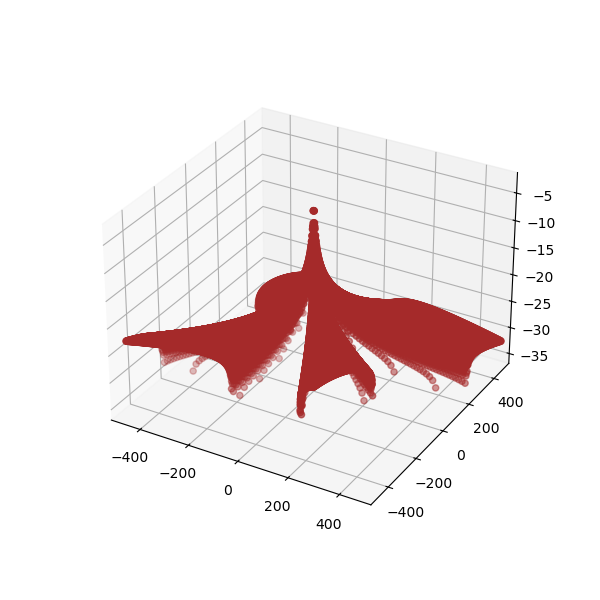

In [40]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim(-500,500)
ax.set_ylim(-500,500)

ax.scatter(lisppn.T[0], lisppn.T[1], np.log(-t00t00_analy_pp), c='brown', marker='o')
ax.scatter(lispmn.T[0], lispmn.T[1], np.log(-t00t00_analy_pm), c='brown', marker='o')
ax.scatter(lismpn.T[0], lismpn.T[1], np.log(-t00t00_analy_mp), c='brown', marker='o')
ax.scatter(lismmn.T[0], lismmn.T[1], np.log(-t00t00_analy_mm), c='brown', marker='o')

In [46]:
r=np.sqrt(lis.T[0]**2+lis.T[1]**2)
theta=np.arctan(lis.T[1]/lis.T[0])

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_2324/1873516206.py:2: RuntimeWarning: divide by zero encountered in divide
  theta=np.arctan(lis.T[1]/lis.T[0])
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_2324/1873516206.py:2: RuntimeWarning: invalid value encountered in divide
  theta=np.arctan(lis.T[1]/lis.T[0])


In [47]:
rcen=80
rmin = rcen-1
rmax = rmin+1

lis2_=[]
for i in range(len(lis)):
    if rmin<r[i]<rmax:
        lis2_.append( [r[i], theta[i], lis[i][2]] )
lis2 = np.array( lis2_ )

In [81]:
coeff = 1.0/6.0

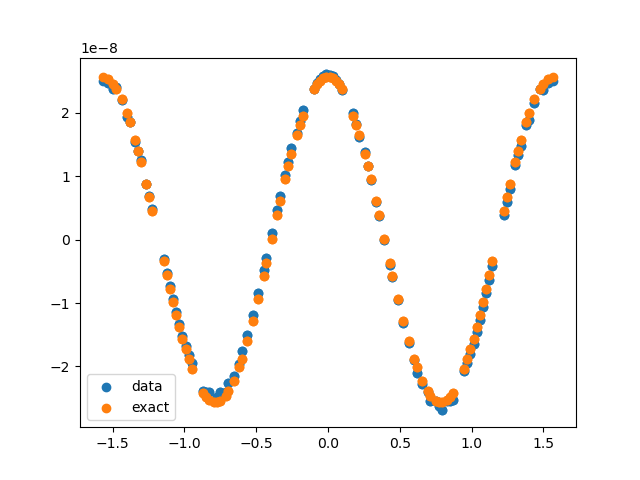

In [82]:
plt.close()
plt.scatter( lis2.T[1], coeff*lis2.T[2], label="data" )
plt.scatter( lis2.T[1], np.cos(4.0*lis2.T[1])/rmin**4, label="exact" )
plt.legend()
plt.show()

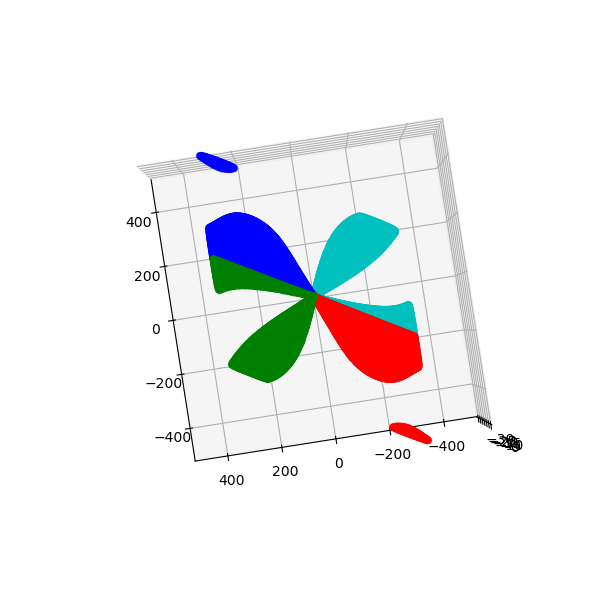

In [50]:
plt.plot( lis2.T[1], lis2.T[2] )
plt.plot( lis2.T[1], 20.0*0.5*np.cos(2.0*lis2.T[1])/rmin**4 )

plt.show()

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_2324/3374374623.py:11: RuntimeWarning: invalid value encountered in log
  ax.scatter(lisppn.T[0], lisppn.T[1], np.log(-lisppn.T[2]), c='b', marker='o')
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_2324/3374374623.py:13: RuntimeWarning: invalid value encountered in log
  ax.scatter(lispmn.T[0], lispmn.T[1], np.log(-lispmn.T[2]), c='c', marker='o')
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_2324/3374374623.py:15: RuntimeWarning: invalid value encountered in log
  ax.scatter(lismpn.T[0], lismpn.T[1], np.log(-lismpn.T[2]), c='g', marker='o')
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_2324/3374374623.py:17: RuntimeWarning: invalid value encountered in log
  ax.scatter(lismmn.T[0], lismmn.T[1], np.log(-lismmn.T[2]), c='r', marker='o')


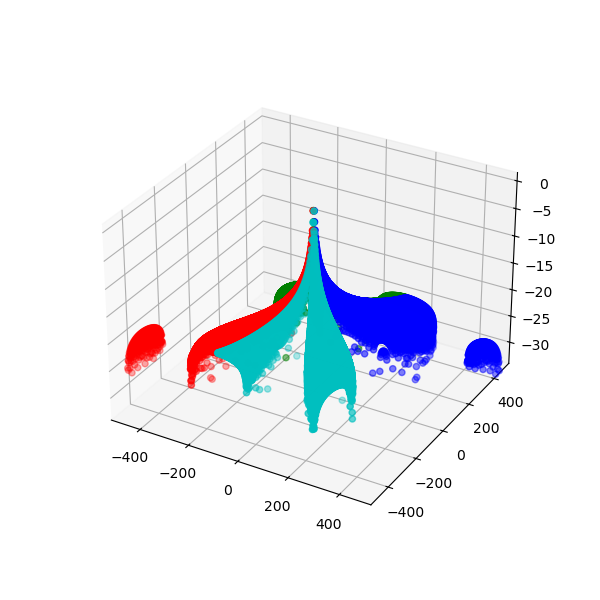

In [41]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim(-500,500)
ax.set_ylim(-500,500)

# ax.scatter(lisppn.T[0], lisppn.T[1], np.log(-t00t00_analytic), c='brown', marker='o')

ax.scatter(lisppn.T[0], lisppn.T[1], np.log(-lisppn.T[2]), c='b', marker='o')

ax.scatter(lispmn.T[0], lispmn.T[1], np.log(-lispmn.T[2]), c='c', marker='o')

ax.scatter(lismpn.T[0], lismpn.T[1], np.log(-lismpn.T[2]), c='g', marker='o')

ax.scatter(lismmn.T[0], lismmn.T[1], np.log(-lismmn.T[2]), c='r', marker='o')

In [132]:
# lismm_=[]
# for elem in T0T0:
#     if Lx/2<=elem[0]<Lx and Ly/2<=elem[2]<Ly:
#         lispp_.append( [elem[0], elem[1], elem[2]] )
# lispp = np.array( lis_ )

In [ ]:
# lismm_=[]
# for elem in T0T0:
#     if Lx/2<=elem[0]<Lx and Ly/2<=elem[2]<Ly:
#         lispp_.append( [elem[0], elem[1], elem[2]] )
# lispp = np.array( lis_ )

In [122]:
lis_=[]
for elem in T0T0:
    # if elem[0])>1.0 and abs(elem[1])>1.0 and abs(elem[0]-767)>1.0 and abs(elem[1]-767)>1.0:
    # lis_.append( [elem[0]+0.5*elem[1], np.sqrt(3)*0.5*elem[1], elem[2]] )
    lis_.append( [elem[0]+0.5*elem[1], np.sqrt(3)*0.5*elem[1], elem[2]] )
lis = np.array( lis_ )

In [123]:
r=np.sqrt(lis.T[0]**2+lis.T[1]**2)
theta=np.arctan(lis.T[1]/lis.T[0])

In [124]:
# r=np.sqrt(T0T0.T[0]**2+T0T0.T[1]**2)
# theta=np.arctan(T0T0.T[1]/T0T0.T[0])

In [125]:
rmin = 10
rmax = 100

rmin<12<rmax

True

In [126]:
rcen=80
rmin = rcen-1
rmax = rmin+1

lis2_=[]
for i in range(len(lis)):
    if rmin<r[i]<rmax:
        lis2_.append( [r[i], theta[i], lis[i][2]] )
lis2 = np.array( lis2_ )

In [127]:
plt.plot( lis2.T[1], lis2.T[2] )

plt.plot( lis2.T[1], 20.0*0.5*np.cos(2.0*lis2.T[1])/rmin**4 )

IndexError: index 1 is out of bounds for axis 0 with size 0

In [63]:
r

array([   0.        ,    3.        ,    6.        , ..., 1323.2902176 ,
       1325.88574168, 1328.48296941])

In [14]:
# np.savetxt( "t0t0.dat", lis )

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_5290/4204264706.py:9: RuntimeWarning: divide by zero encountered in divide
  y=1.0/x**2
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_5290/4204264706.py:12: RuntimeWarning: divide by zero encountered in divide
  y=10.0/x**4


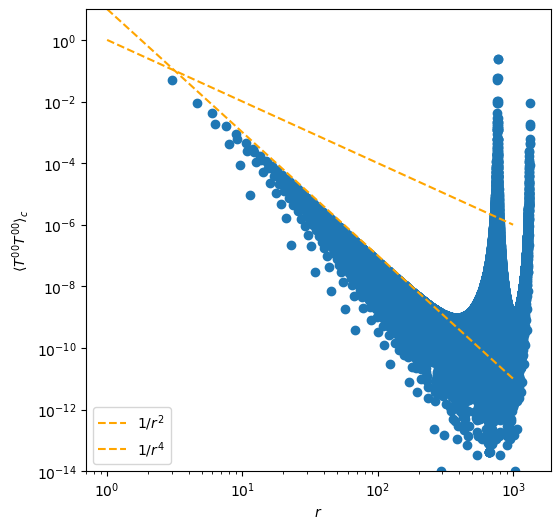

In [15]:
plt.close()

plt.figure(figsize=(6, 6))

plt.scatter( np.sqrt(lis.T[0]**2+lis.T[1]**2), lis.T[2] )
# plt.scatter( lis.T[2], np.abs(lis.T[3]), alpha=0.2 )

x=np.arange( 1000 )
y=1.0/x**2
plt.plot( x,y, ls="dashed", c="orange", label="$1/r^2$" )

y=10.0/x**4
plt.plot( x,y, ls="dashed", c="orange", label="$1/r^4$" )

plt.yscale("log")
plt.xscale("log")
plt.ylim( 1.0e-14, 10 )

plt.legend()
plt.xlabel("$r$")
plt.ylabel("$\\langle T^{00} T^{00}\\rangle_{c}$")

plt.savefig("t00t00_2dplot_"+str(Lx)+".pdf", bbox_inches="tight")

In [16]:
z = lis.T[0]+1.0j*lis.T[1]

In [41]:
t00t00_analytic = np.real(0.5/z**4)

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_5290/543819289.py:1: RuntimeWarning: divide by zero encountered in divide
  t00t00_analytic = np.real(0.5/z**4)
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_5290/543819289.py:1: RuntimeWarning: invalid value encountered in divide
  t00t00_analytic = np.real(0.5/z**4)


In [44]:
coeff = 1.0/(9.0*alat**2)

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_5290/1151933407.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot( np.abs(t00t00_analytic-coeff*lis.T[2])/t00t00_analytic )
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_5290/1151933407.py:4: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-12.0, 2000.0)


(0.0683611465610763, 2000.0)

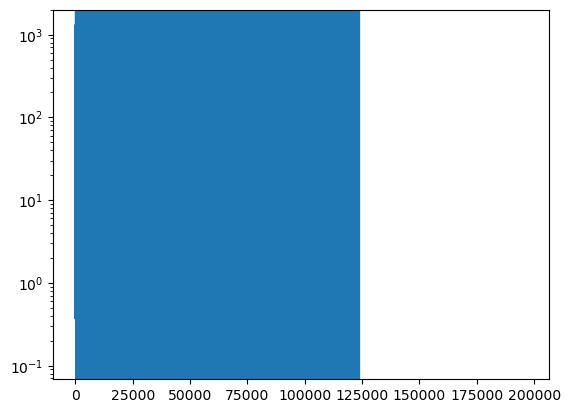

In [49]:
plt.plot( np.abs(t00t00_analytic-coeff*lis.T[2])/t00t00_analytic )

plt.yscale("log")
plt.ylim(-12.0, 2000.0)

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_5290/3485521690.py:6: RuntimeWarning: invalid value encountered in log
  ax.scatter(lis.T[0], lis.T[1], 3.0+np.log(t00t00_analytic), c='b', marker='o')


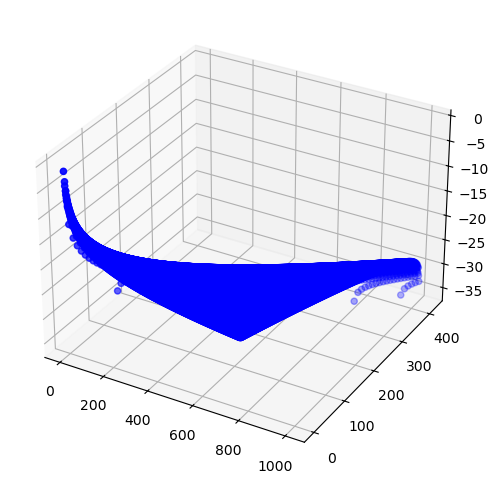

In [18]:
plt.close()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(lis.T[0], lis.T[1], 3.0+np.log(t00t00_analytic), c='b', marker='o')

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_5290/1143535564.py:6: RuntimeWarning: invalid value encountered in log
  ax.scatter(lis.T[0], lis.T[1], np.log(lis.T[2]), c='r', marker='o',
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_5290/1143535564.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(lis.T[0], lis.T[1], np.log(t00t00_analytic), c='b', marker='o',


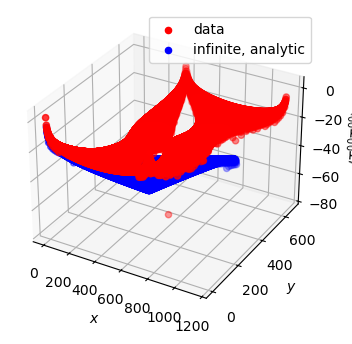

In [19]:
plt.close()

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(lis.T[0], lis.T[1], np.log(lis.T[2]), c='r', marker='o',
          label="data")
# ax.scatter(lis.T[0], lis.T[1], np.log(-lis.T[2]), c='c', marker='o')

ax.scatter(lis.T[0], lis.T[1], np.log(t00t00_analytic), c='b', marker='o',
          label="infinite, analytic")
# ax.scatter(lis.T[0], lis.T[1], np.log(np.abs(lis.T[3])), c='b', alpha=0.1, marker='.')

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# ax.set_zscale("log")

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$\\langle T^{00} T^{00}\\rangle_{c}$")

plt.legend()

plt.savefig("t00t00_3dplot_"+str(Lx)+".pdf", bbox_inches="tight")

plt.show()

In [20]:
tmp1 = tt0022 - 0.5*(tt0020+tt0021) - 0.5*(tt0122+tt0222) + 0.25*(tt0120+tt0121+tt0220+tt0221)
tmp2 = tt0011 - 0.5*(tt0012+tt0010) - 0.5*(tt0111+tt0211) + 0.25*(tt0112+tt0110+tt0212+tt0210)
TxxTxy = np.array([tt0000.T[0], tt0000.T[1], 0.5*(tmp1.T[2]-tmp2.T[2])]).T

In [21]:
lis_=[]
for elem in TxxTxy:
    # if elem[0])>1.0 and abs(elem[1])>1.0 and abs(elem[0]-767)>1.0 and abs(elem[1]-767)>1.0:
    lis_.append( [elem[0]+0.5*elem[1], np.sqrt(3)*0.5*elem[1], elem[2]] )
lis = np.array( lis_ )

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_5290/4236539586.py:9: RuntimeWarning: divide by zero encountered in divide
  y=1.0/x**2
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_5290/4236539586.py:12: RuntimeWarning: divide by zero encountered in divide
  y=10.0/x**4


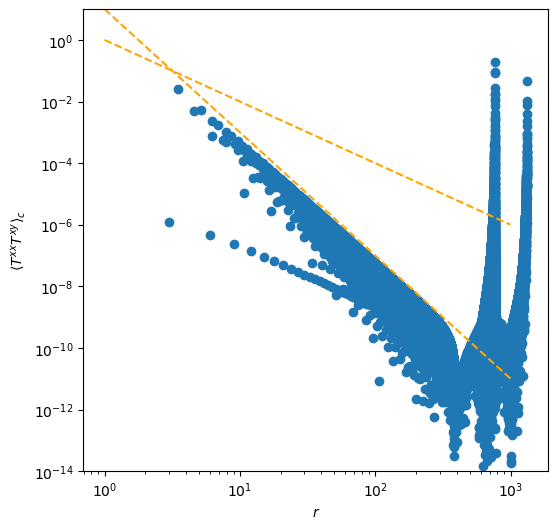

In [22]:
plt.close()

plt.figure(figsize=(6, 6))

plt.scatter( np.sqrt(lis.T[0]**2+lis.T[1]**2), lis.T[2] )
# plt.scatter( lis.T[2], np.abs(lis.T[3]), alpha=0.2 )

x=np.arange( 1000 )
y=1.0/x**2
plt.plot( x,y, ls="dashed", c="orange", label="$1/r^2$" )

y=10.0/x**4
plt.plot( x,y, ls="dashed", c="orange", label="$1/r^4$" )

plt.yscale("log")
plt.xscale("log")
plt.ylim( 1.0e-14, 10 )

plt.xlabel("$r$")
plt.ylabel("$\\langle T^{xx} T^{xy}\\rangle_{c}$")

plt.savefig("txxtxy_2dplot_"+str(Lx)+".pdf", bbox_inches="tight")

In [23]:
rlist = np.sqrt(lis.T[0]**2+lis.T[1]**2)

In [24]:
lis_=[]
for elem in TxxTxy:
    # if elem[0])>1.0 and abs(elem[1])>1.0 and abs(elem[0]-767)>1.0 and abs(elem[1]-767)>1.0:
    lis_.append( [elem[0]+0.5*elem[1], np.sqrt(3)*0.5*elem[1], elem[2], np.sqrt(elem[0]**2+elem[1]**2)] )
lis = np.array( lis_ )

In [25]:
dbg_=[]

for elem in lis:
    if elem[3]<25 and elem[2]<0.5e-6:
      dbg_.append(elem)
dbg = np.array( dbg_ )

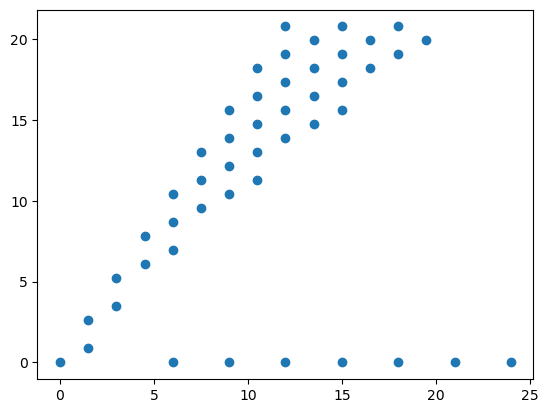

In [26]:
plt.scatter( dbg.T[0], dbg.T[1] )
plt.savefig("wrong_points"+str(Lx)+".pdf")

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_5290/262058952.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(dbg.T[3], 0.2e-5/dbg.T[3]**2)


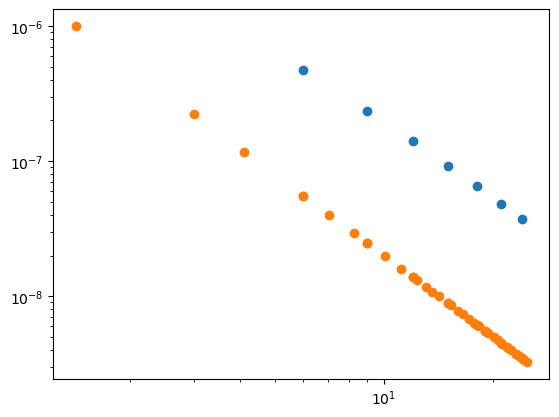

In [27]:
plt.scatter(dbg.T[3], dbg.T[2])

plt.scatter(dbg.T[3], 0.2e-5/dbg.T[3]**2)

plt.xscale("log")
plt.yscale("log")

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_5290/3258558208.py:6: RuntimeWarning: invalid value encountered in log
  ax.scatter(lis.T[0], lis.T[1], np.log(lis.T[2]), c='r', marker='o')
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_5290/3258558208.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(lis.T[0], lis.T[1], np.log(t00t00_analytic), c='b', marker='o')


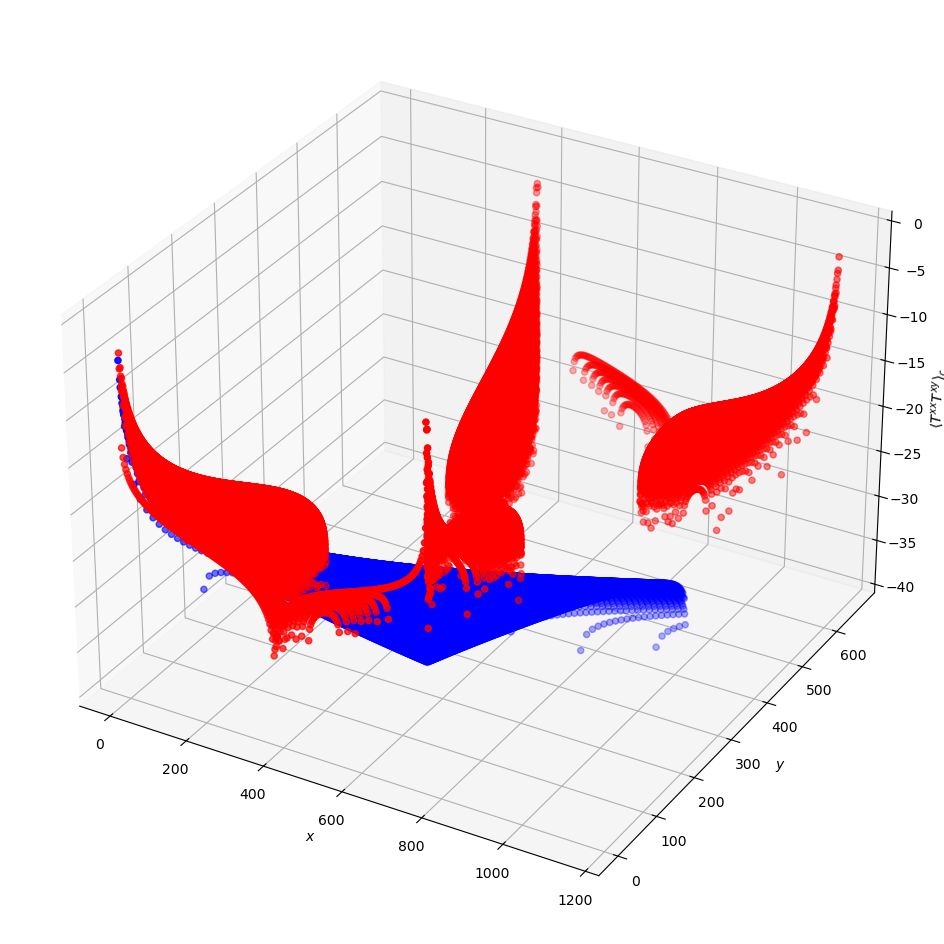

In [28]:
plt.close()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(lis.T[0], lis.T[1], np.log(lis.T[2]), c='r', marker='o')
# ax.scatter(lis.T[0], lis.T[1], np.log(-lis.T[2]), c='c', marker='o')

ax.scatter(lis.T[0], lis.T[1], np.log(t00t00_analytic), c='b', marker='o')
# ax.scatter(lis.T[0], lis.T[1], np.log(np.abs(lis.T[3])), c='b', alpha=0.1, marker='.')

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# ax.set_zscale("log")

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$\\langle T^{xx} T^{xy}\\rangle_{c}$")

plt.savefig("txxtxy_3dplot_"+str(Lx)+".pdf", bbox_inches="tight")

plt.show()

/tmp/ipykernel_11453/633924454.py:5: RuntimeWarning: invalid value encountered in log
  ax.scatter(lis.T[0], lis.T[1], np.log(-lis.T[2]), c='r', marker='o')
/tmp/ipykernel_11453/633924454.py:7: RuntimeWarning: invalid value encountered in log
  ax.scatter(lis.T[0], lis.T[1], 3.0+np.log(-t00t00_analytic), c='b', marker='o')


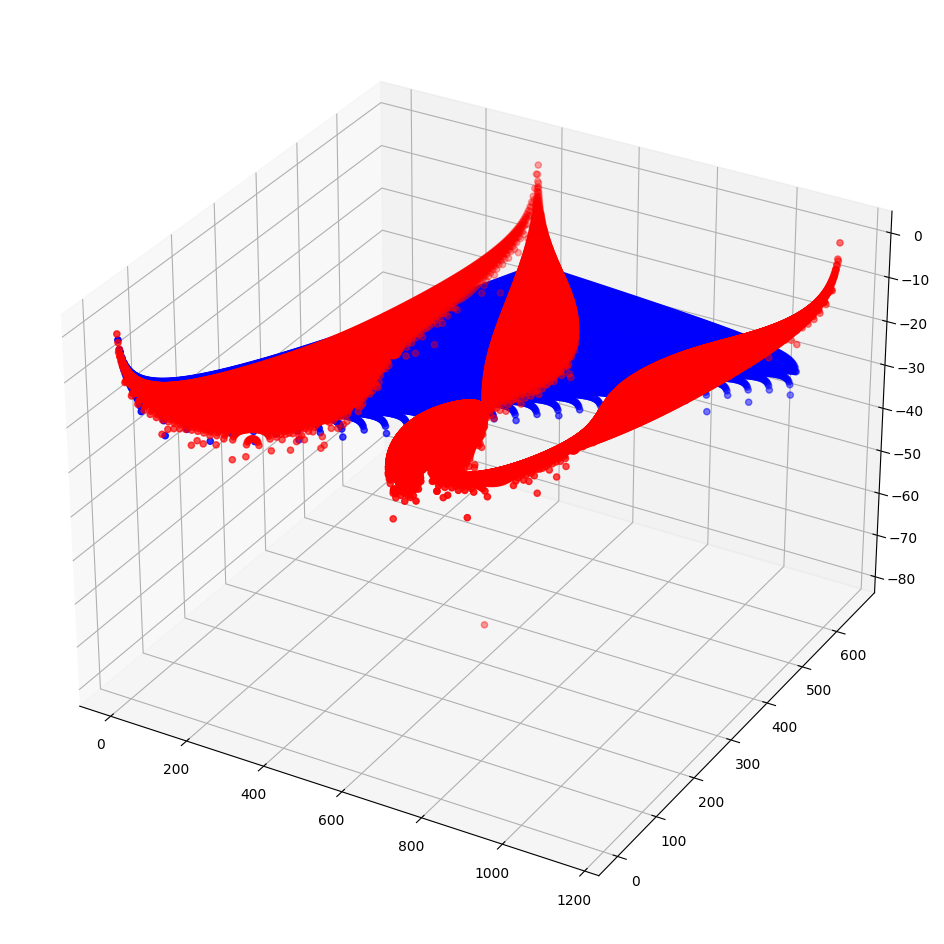

In [25]:
plt.close()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lis.T[0], lis.T[1], np.log(-lis.T[2]), c='r', marker='o')

ax.scatter(lis.T[0], lis.T[1], 3.0+np.log(-t00t00_analytic), c='b', marker='o')
# ax.scatter(lis.T[0], lis.T[1], np.log(np.abs(lis.T[3])), c='b', alpha=0.1, marker='.')

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# ax.set_zscale("log")

plt.show()

In [2]:
tt0000 = np.loadtxt("../data/m0.000000Lx768Ly768alat0.010000ortho1tt0000.dat")
tt0001 = np.loadtxt("../data/m0.000000Lx768Ly768alat0.010000ortho1tt0001.dat")
tt0002 = np.loadtxt("../data/m0.000000Lx768Ly768alat0.010000ortho1tt0002.dat")

tt0100 = np.loadtxt("../data/m0.000000Lx768Ly768alat0.010000ortho1tt0100.dat")
tt0101 = np.loadtxt("../data/m0.000000Lx768Ly768alat0.010000ortho1tt0101.dat")
tt0102 = np.loadtxt("../data/m0.000000Lx768Ly768alat0.010000ortho1tt0102.dat")

tt0200 = np.loadtxt("../data/m0.000000Lx768Ly768alat0.010000ortho1tt0200.dat")
tt0201 = np.loadtxt("../data/m0.000000Lx768Ly768alat0.010000ortho1tt0201.dat")
tt0202 = np.loadtxt("../data/m0.000000Lx768Ly768alat0.010000ortho1tt0202.dat")

In [3]:
alat = 0.01
Lx = 768
Ly = 768
m = 0.0

In [4]:
T0T0 = tt0000 - 0.5*(tt0001+tt0002) - 0.5*(tt0100+tt0200) + 0.25*(tt0101+tt0102+tt0201+tt0202)
T0T0 = np.array([tt0000.T[0], tt0000.T[1], T0T0.T[2]]).T

In [5]:
lis_=[]
for elem in T0T0:
    # if abs(elem[0])>1.0 and abs(elem[1])>1.0 and abs(elem[0]-767)>1.0 and abs(elem[1]-767)>1.0:
    lis_.append( [elem[0], elem[1], np.sqrt(elem[0]**2+elem[1]**2), elem[2]] )
lis = np.array( lis_ )

In [6]:
lis

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.74993959e+00],
       [3.00000000e+00, 0.00000000e+00, 3.00000000e+00, 4.84269164e-02],
       [6.00000000e+00, 0.00000000e+00, 6.00000000e+00, 4.25461213e-03],
       ...,
       [7.61000000e+02, 7.67000000e+02, 1.08046749e+03, 8.02969664e-10],
       [7.64000000e+02, 7.67000000e+02, 1.08258256e+03, 8.05144522e-10],
       [7.67000000e+02, 7.67000000e+02, 1.08470180e+03, 8.04235874e-10]])

In [7]:
lis.T[2].size

196608

In [8]:
lis.T[3].size

196608

(1e-10, 10)

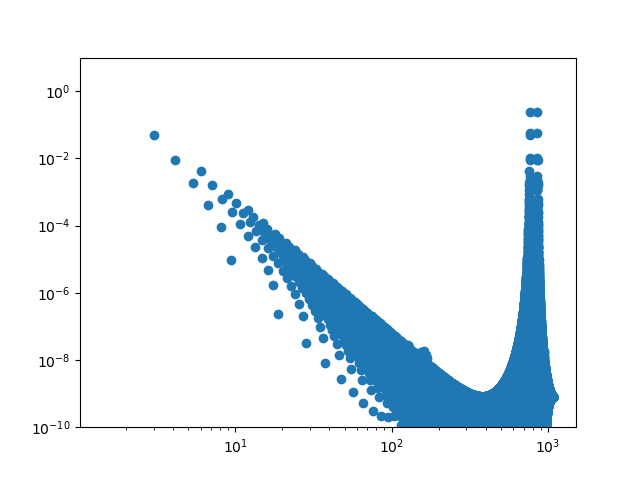

In [9]:
plt.scatter( lis.T[2], lis.T[3] )

# x=np.arange( 1000 )
# y=1.0/x**2
# plt.plot( x,y, ls="dashed", c="orange" )

# y=10.0/x**4
# plt.plot( x,y, ls="dashed", c="orange" )

plt.yscale("log")
plt.xscale("log")
plt.ylim( 1.0e-10, 10 )

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_20673/3547504063.py:3: RuntimeWarning: invalid value encountered in log
  ax.scatter(lis.T[0], lis.T[1], np.log(lis.T[3]), c='r', marker='o')


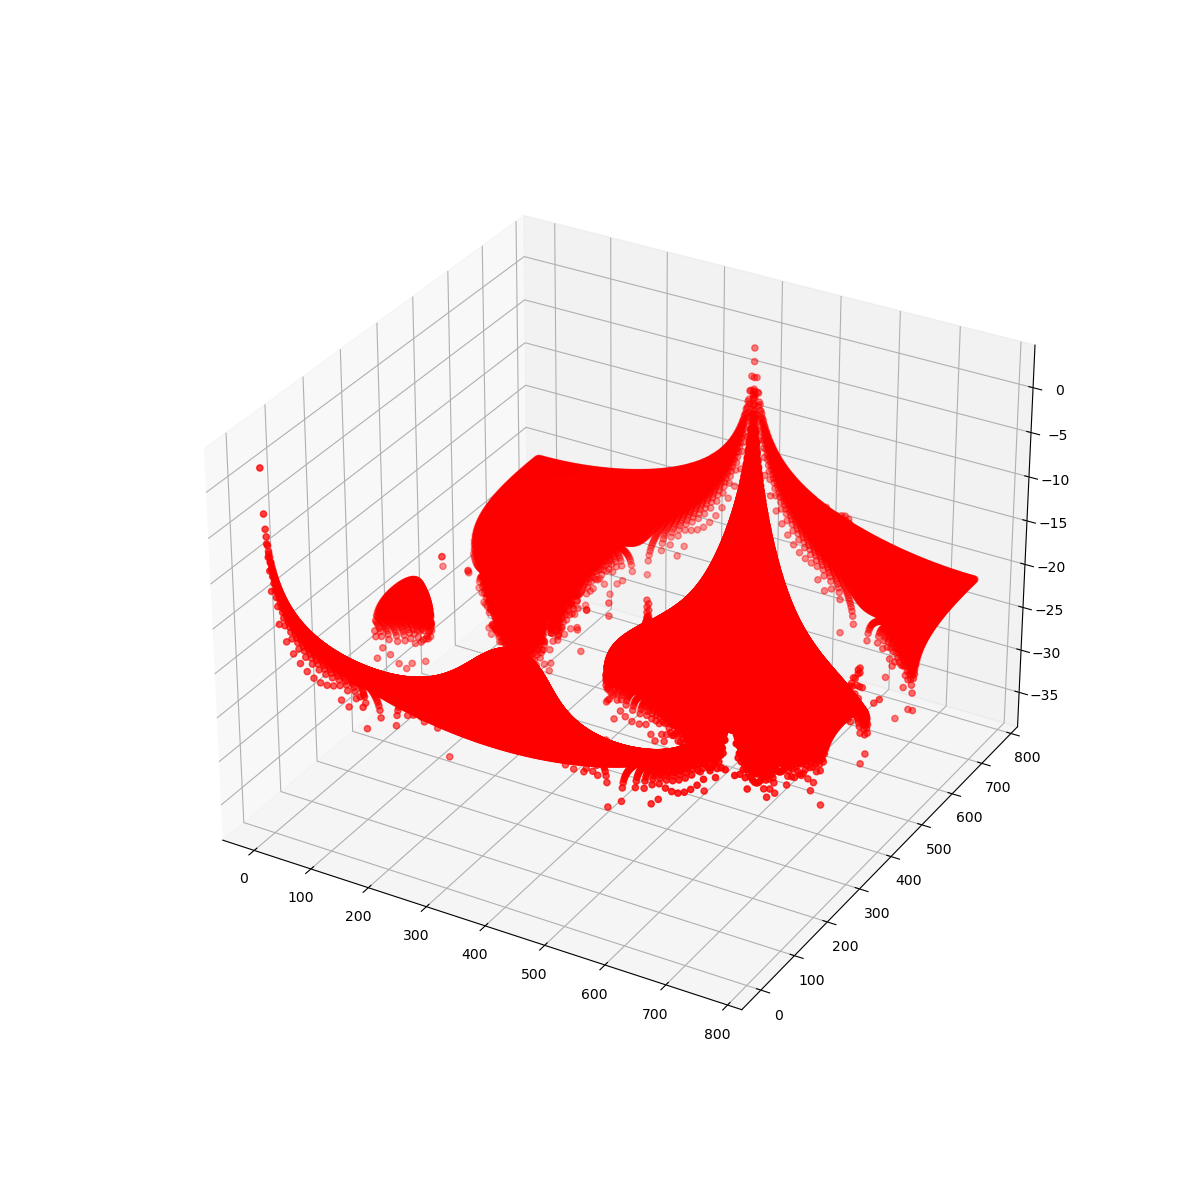

In [10]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lis.T[0], lis.T[1], np.log(lis.T[3]), c='r', marker='o')

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# ax.set_zscale("log")

plt.show()

In [9]:
# x, y, a, b, c, s

In [20]:
ta0b0c0d0_ = []
for elem in tt:
    if elem[2]==0 and elem[3]==0 and elem[4]==0 and elem[5]==0:
        ta0b0c0d0_.append( [elem[0], elem[1], np.sqrt(elem[0]**2+elem[1]**2), elem[6]] )
ta0b0c0d0 = np.array(ta0b0c0d0_)

In [21]:
ta0b0c0d0

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         4.50000000e+00],
       [ 3.00000000e+00,  0.00000000e+00,  3.00000000e+00,
        -1.45734812e-01],
       [ 6.00000000e+00,  0.00000000e+00,  6.00000000e+00,
        -3.78437452e-02],
       ...,
       [ 7.61000000e+02,  7.67000000e+02,  1.08046749e+03,
        -2.33406700e-02],
       [ 7.64000000e+02,  7.67000000e+02,  1.08258256e+03,
        -6.01485111e-02],
       [ 7.67000000e+02,  7.67000000e+02,  1.08470180e+03,
        -2.63169323e-01]])

/tmp/ipykernel_142732/941853031.py:4: RuntimeWarning: divide by zero encountered in divide
  y=1.0/x**2
/tmp/ipykernel_142732/941853031.py:7: RuntimeWarning: divide by zero encountered in divide
  y=10.0/x**4


(1e-10, 10)

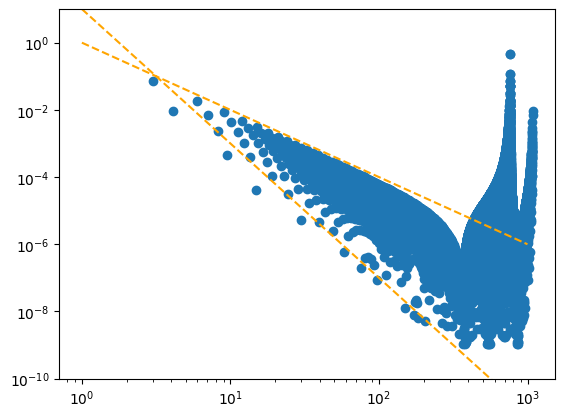

In [34]:
plt.scatter( ta0b0c0d0.T[2], ta0b0c0d0.T[3] )

x=np.arange( 1000 )
y=1.0/x**2
plt.plot( x,y, ls="dashed", c="orange" )

y=10.0/x**4
plt.plot( x,y, ls="dashed", c="orange" )

plt.yscale("log")
plt.xscale("log")
plt.ylim( 1.0e-10, 10 )

In [ ]:
tt.T[6]

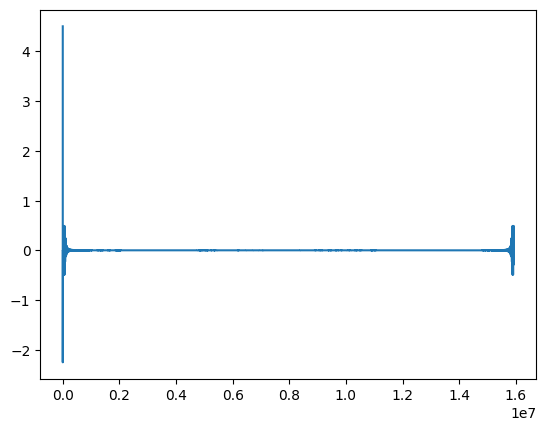

In [15]:
plt.plot(tt.T[6])

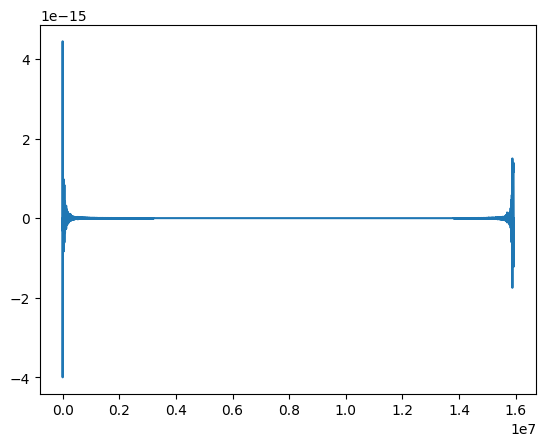

In [17]:
plt.plot(tt.T[7])

In [5]:
def const_exp(x, E0, A, dE):
    return E0 + A*np.exp(-dE*x)

def e_m_k( k, m, A ):
    return A*np.sqrt( m**2 + k**2 )

def e_m( k, m ):
    return np.sqrt( m**2 + k**2 )

In [5]:
fftd_=[]

nn = int(Lx*2/3)

for y1 in range(int(Ly/2)):
    line_chosen=[]
    for line in eps[y1*nn:y1*nn+nn]:
        if line[4]==0:
            if line[1] == y1:
                line_chosen.append([line[0], line[1], line[2] ])
    tslice = np.array( line_chosen ).T[2]
    tsliceF = np.fft.fft( tslice )
    fftd_.append( tsliceF )
fftd=np.array(fftd_)

In [6]:
toplot1 = np.array([ [np.sqrt(line[0]**2+line[1]**2), line[2]] for line in eps ])

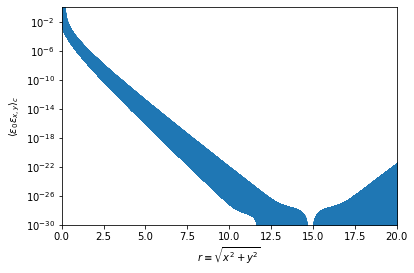

In [76]:
plt.scatter( toplot1.T[0]*alat, toplot1.T[1], rasterized=True )
plt.yscale( "log" )

plt.xlabel( "$r\\equiv \\sqrt{x^2+y^2}$" )
plt.ylabel( "$\\langle \\varepsilon_0 \\varepsilon_{x,y} \\rangle_c$" )

plt.xlim(0, 20.0)
plt.ylim(1.0e-30, 1.0)

plt.savefig( "epseps_corr.pdf", bbox_inches="tight" )

In [10]:
meff_allk_=[]
for k in range(fftd.shape[1]):
    meff=-np.log(fftd.T[k][1:]/fftd.T[k][:-1]).real
    meff_allk_.append(meff)
meff_allk = np.array(meff_allk_)

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_3512/2531294647.py:3: RuntimeWarning: divide by zero encountered in true_divide
  meff=-np.log(fftd.T[k][1:]/fftd.T[k][:-1]).real
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_3512/2531294647.py:3: RuntimeWarning: divide by zero encountered in log
  meff=-np.log(fftd.T[k][1:]/fftd.T[k][:-1]).real
/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_3512/2531294647.py:3: RuntimeWarning: invalid value encountered in true_divide
  meff=-np.log(fftd.T[k][1:]/fftd.T[k][:-1]).real


In [37]:
fitm=400
fitM=550

fit_range_=[
    [0,40,80],
#     [1,300,500],
#     [2,300,500],
#     [3,300,500],
#     [4,300,500],
#     [5,300,500],
#     [6,300,500],
#     [7,300,500],
#     [8,300,500],
#     [9,300,500],
#     [10,300,500],
#     [11,300,500],
#     [12,300,500],
#     [13,300,500],
#     [14,300,500],
#     [15,300,400],
#     [16,300,400],
#     [17,300,400],
#     [18,300,400],
#     [19,300,400],
#     [20,250,350],
#     [21,250,350],
#     [22,250,350],
#     [23,250,350],
#     [24,200,300],
]

fit_range=np.array(fit_range_)

(4, 10.0)

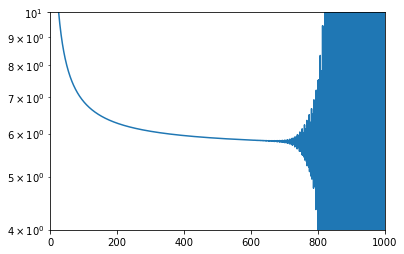

In [42]:
k=25
y = meff_allk[k] / alat
plt.plot(y)
plt.yscale("log")
plt.xlim(0,1000)
plt.ylim(4, 10.0)

(array([3.58358873, 1.06994068, 0.41383698]), array([[1.10524959e-07, 7.21987621e-07, 2.99707893e-07],
       [7.21987621e-07, 4.84671215e-06, 1.98411852e-06],
       [2.99707893e-07, 1.98411852e-06, 8.18066220e-07]]))


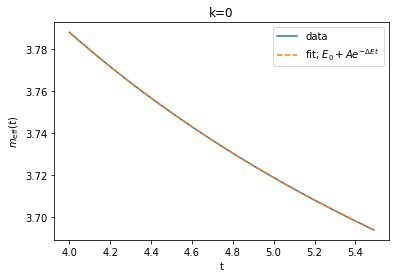

(array([3.58815184, 1.0698025 , 0.41382677]), array([[1.10509008e-07, 7.21812734e-07, 2.99681676e-07],
       [7.21812734e-07, 4.84506391e-06, 1.98375005e-06],
       [2.99681676e-07, 1.98375005e-06, 8.18040898e-07]]))


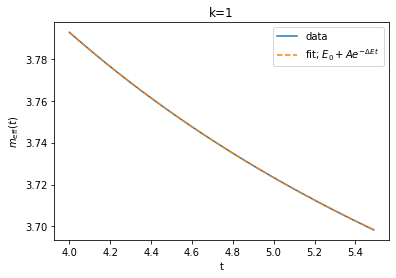

(array([3.60180497, 1.06939031, 0.41379635]), array([[1.10461238e-07, 7.21290683e-07, 2.99603147e-07],
       [7.21290683e-07, 4.84015130e-06, 1.98265104e-06],
       [2.99603147e-07, 1.98265104e-06, 8.17965019e-07]]))


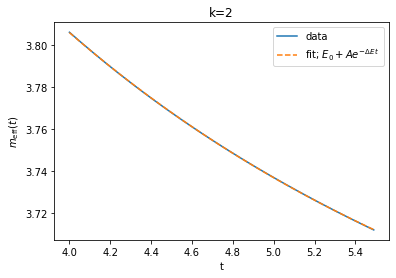

(array([3.6244408 , 1.06871086, 0.41374628]), array([[1.10382736e-07, 7.20431121e-07, 2.99474193e-07],
       [7.20431121e-07, 4.83205765e-06, 1.98084057e-06],
       [2.99474193e-07, 1.98084057e-06, 8.17840924e-07]]))


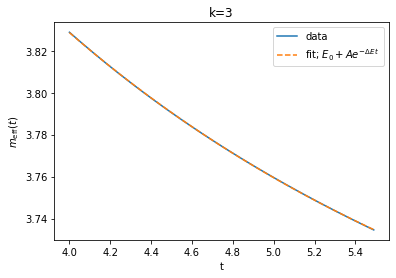

(array([3.65588515, 1.0677751 , 0.41367752]), array([[1.10274393e-07, 7.19249036e-07, 2.99296601e-07],
       [7.19249036e-07, 4.82094775e-06, 1.97835523e-06],
       [2.99296601e-07, 1.97835523e-06, 8.17671981e-07]]))


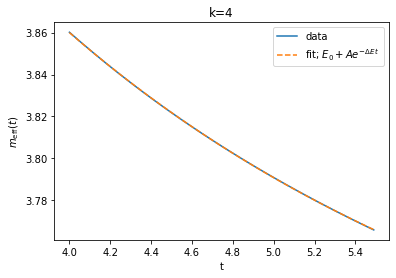

(array([3.69590341, 1.06659757, 0.41359132]), array([[1.10138231e-07, 7.17767002e-07, 2.99074434e-07],
       [7.17767002e-07, 4.80703845e-06, 1.97524680e-06],
       [2.99074434e-07, 1.97524680e-06, 8.17465589e-07]]))


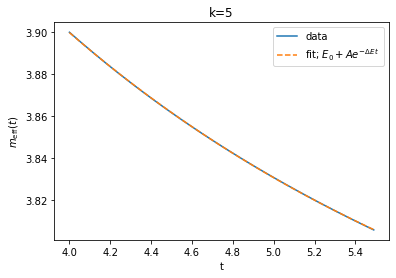

(array([3.74420887, 1.06519564, 0.41348916]), array([[1.09975483e-07, 7.16003604e-07, 2.98809186e-07],
       [7.16003604e-07, 4.79052969e-06, 1.97155353e-06],
       [2.98809186e-07, 1.97155353e-06, 8.17221105e-07]]))


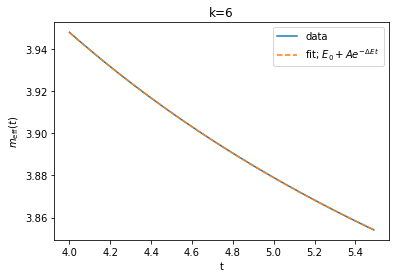

(array([3.80047219, 1.06358877, 0.41337271]), array([[1.09788495e-07, 7.13987171e-07, 2.98505413e-07],
       [7.13987171e-07, 4.77170205e-06, 1.96734040e-06],
       [2.98505413e-07, 1.96734040e-06, 8.16946316e-07]]))


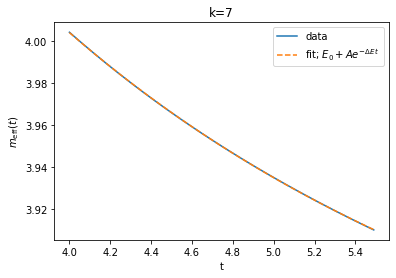

(array([3.86433139, 1.06179789, 0.41324376]), array([[1.09580406e-07, 7.11751989e-07, 2.98169675e-07],
       [7.11751989e-07, 4.75088040e-06, 1.96268767e-06],
       [2.98169675e-07, 1.96268767e-06, 8.16654088e-07]]))


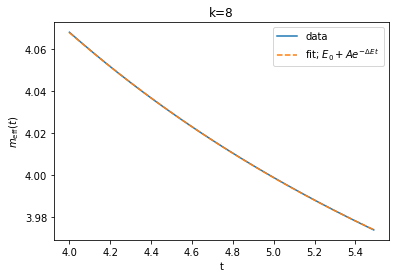

(array([3.93540167, 1.05984445, 0.41310415]), array([[1.09351595e-07, 7.09312929e-07, 2.97800618e-07],
       [7.09312929e-07, 4.72825311e-06, 1.95762014e-06],
       [2.97800618e-07, 1.95762014e-06, 8.16334634e-07]]))


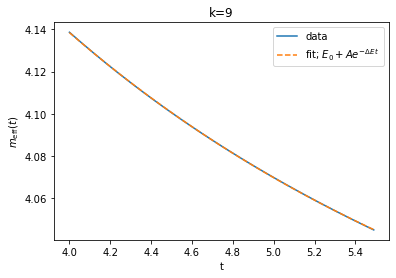

(array([4.0132847 , 1.05774979, 0.41295566]), array([[1.09106098e-07, 7.06710845e-07, 2.97407301e-07],
       [7.06710845e-07, 4.70419175e-06, 1.95223649e-06],
       [2.97407301e-07, 1.95223649e-06, 8.16007777e-07]]))


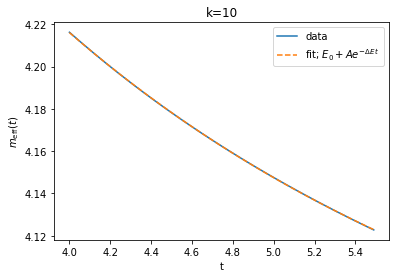

(array([4.09757691, 1.05553482, 0.41280008]), array([[1.08846087e-07, 7.03972882e-07, 2.96993539e-07],
       [7.03972882e-07, 4.67896706e-06, 1.94659702e-06],
       [2.96993539e-07, 1.94659702e-06, 8.15678584e-07]]))


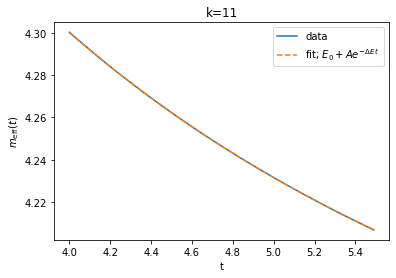

(array([4.1878766 , 1.05321932, 0.41263906]), array([[1.08573279e-07, 7.01121199e-07, 2.96561712e-07],
       [7.01121199e-07, 4.65280285e-06, 1.94074724e-06],
       [2.96561712e-07, 1.94074724e-06, 8.15347638e-07]]))


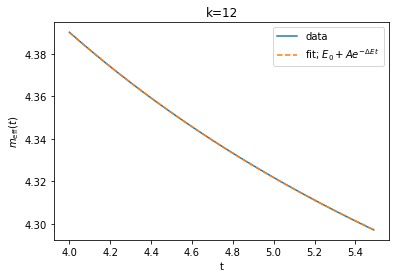

(array([4.28378979, 1.05082186, 0.41247413]), array([[1.08289216e-07, 6.98177899e-07, 2.96114275e-07],
       [6.98177899e-07, 4.62592858e-06, 1.93473626e-06],
       [2.96114275e-07, 1.93473626e-06, 8.15017224e-07]]))


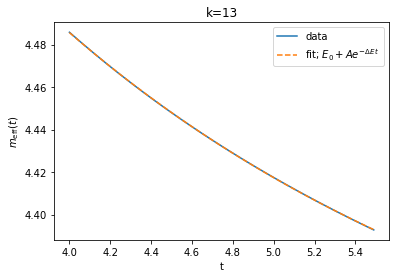

(array([4.38493486, 1.04835954, 0.41230675]), array([[1.07996981e-07, 6.95172095e-07, 2.95657602e-07],
       [6.95172095e-07, 4.59859821e-06, 1.92863048e-06],
       [2.95657602e-07, 1.92863048e-06, 8.14699476e-07]]))


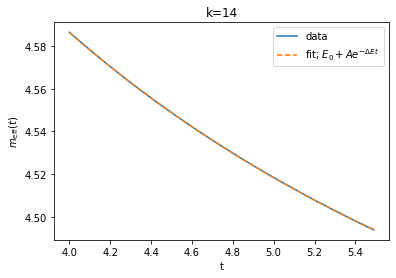

(array([4.49094584, 1.04584778, 0.41213813]), array([[1.07697778e-07, 6.92120491e-07, 2.95193294e-07],
       [6.92120491e-07, 4.57098284e-06, 1.92246491e-06],
       [2.95193294e-07, 1.92246491e-06, 8.14394461e-07]]))


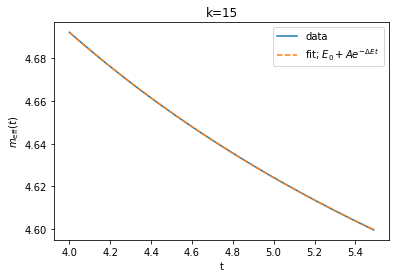

(array([4.60147491, 1.04330032, 0.41196935]), array([[1.07393120e-07, 6.89040905e-07, 2.94723973e-07],
       [6.89040905e-07, 4.54325413e-06, 1.91627888e-06],
       [2.94723973e-07, 1.91627888e-06, 8.14105499e-07]]))


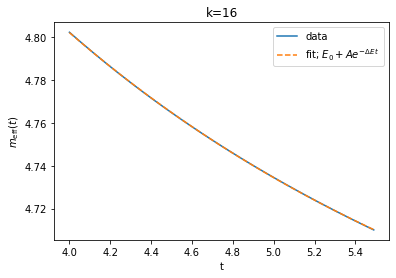

(array([4.71619381, 1.04072941, 0.41180135]), array([[1.07086267e-07, 6.85959950e-07, 2.94256929e-07],
       [6.85959950e-07, 4.51562413e-06, 1.91013529e-06],
       [2.94256929e-07, 1.91013529e-06, 8.13848352e-07]]))


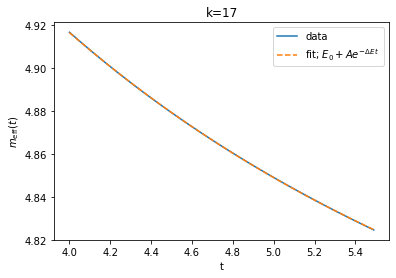

(array([4.83479454, 1.03814535, 0.41163478]), array([[1.06782056e-07, 6.82912917e-07, 2.93803912e-07],
       [6.82912917e-07, 4.48835229e-06, 1.90412220e-06],
       [2.93803912e-07, 1.90412220e-06, 8.13651447e-07]]))


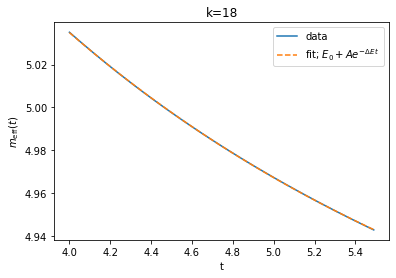

(array([4.9569896 , 1.03555707, 0.41147013]), array([[1.06487504e-07, 6.79947920e-07, 2.93382823e-07],
       [6.79947920e-07, 4.46177610e-06, 1.89836479e-06],
       [2.93382823e-07, 1.89836479e-06, 8.13560684e-07]]))


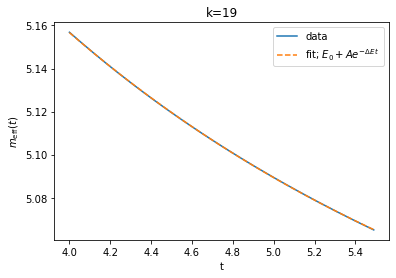

(array([5.08251157, 1.03297155, 0.41130751]), array([[1.06217939e-07, 6.77161985e-07, 2.93034101e-07],
       [6.77161985e-07, 4.43652554e-06, 1.89312234e-06],
       [2.93034101e-07, 1.89312234e-06, 8.13683332e-07]]))


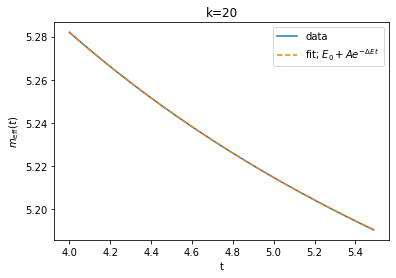

(array([5.21111252, 1.0303937 , 0.4111465 ]), array([[1.06005908e-07, 6.74760444e-07, 2.92846026e-07],
       [6.74760444e-07, 4.41392924e-06, 1.88895889e-06],
       [2.92846026e-07, 1.88895889e-06, 8.14260374e-07]]))


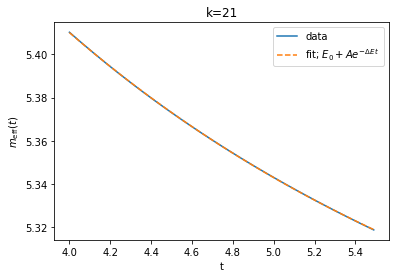

(array([5.34256324, 1.02782742, 0.41098658]), array([[1.05922542e-07, 6.73188736e-07, 2.93013506e-07],
       [6.73188736e-07, 4.39685349e-06, 1.88711140e-06],
       [2.93013506e-07, 1.88711140e-06, 8.15829366e-07]]))


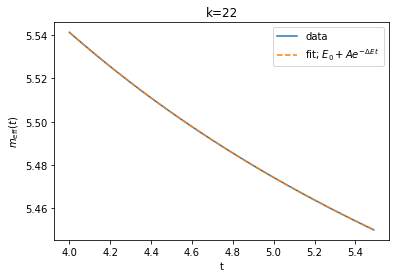

(array([5.47665254, 1.02527696, 0.41082777]), array([[1.06164565e-07, 6.73691550e-07, 2.94081744e-07],
       [6.73691550e-07, 4.39339118e-06, 1.89107564e-06],
       [2.94081744e-07, 1.89107564e-06, 8.19911119e-07]]))


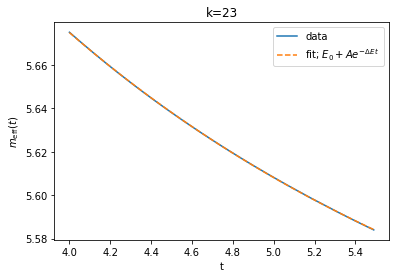

(array([5.61318728, 1.02275331, 0.41067351]), array([[1.07335981e-07, 6.80109430e-07, 2.97733937e-07],
       [6.80109430e-07, 4.42863702e-06, 1.91169703e-06],
       [2.97733937e-07, 1.91169703e-06, 8.31226592e-07]]))


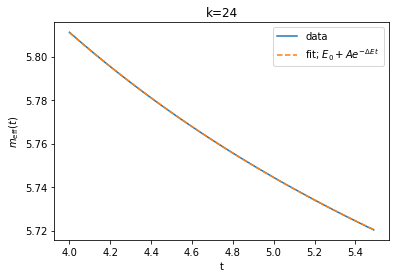

In [61]:
kmax=25

e0_list_=[]
p0 = [2*m, 1.0, 1.0]

for k in range(kmax):
    x=np.arange(fitm,fitM) * alat
    y=meff_allk[k][fitm:fitM] / alat

#     x=np.arange(fit_range[k][1],fit_range[k][2]) * alat
#     y=meff_allk[k][fit_range[k][1]:fit_range[k][2]] / alat

    plt.plot( x, y, label="data" )
    # plt.ylim(0, 0.04)

    fit=sp.optimize.curve_fit(const_exp, x, y, p0)
    plt.plot( x, const_exp( x, fit[0][0], fit[0][1], fit[0][2] ), 
             label="fit; $E_0 + Ae^{-\\Delta E \, t}$",
             ls="dashed")
    p0 = fit[0]
    print(fit)

    plt.title("k="+str(k))
    plt.legend()
    plt.xlabel("t")
    plt.ylabel("$m_{\\rm eff}(t)$")
    plt.savefig( "fit"+str(k)+".pdf", bbox_inches="tight" )
    plt.show()

    e0_list_.append([k, fit[0][0]])

e0_list = np.array(e0_list_)

(array([4.07113268, 0.8806418 ]),
 array([[ 1.73556671e-06, -2.51171870e-07],
        [-2.51171870e-07,  3.95243280e-08]]))

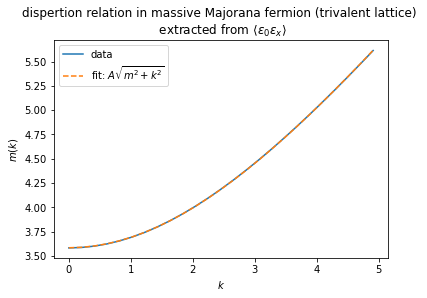

In [58]:
x = e0_list.T[0] * 2.0*np.pi/(Lx*alat)
y = e0_list.T[1] # / (0.5*np.sqrt(3))

plt.plot( x, y, label="data" )

fit=sp.optimize.curve_fit(e_m_k, x, y, p0=[m*2, 1.0])
plt.plot( x, e_m_k( x, fit[0][0], fit[0][1] ), label="fit: $A \\sqrt{m^2+k^2}$", ls="dashed" )

# fit=sp.optimize.curve_fit(e_m, x, y, p0=[m*2])
# plt.plot( x, e_m( x, fit[0][0] ), label="fit" )

# plt.plot( x, x )

plt.xlabel( "$k$" )
plt.ylabel( "$m(k)$" )

plt.legend()

plt.title("dispertion relation in massive Majorana fermion (trivalent lattice) \n extracted from $\\langle \\varepsilon_0 \\varepsilon_x \\rangle$")
plt.savefig( "dispertion_relation.pdf", bbox_inches="tight" )

fit

In [46]:
0.5*np.sqrt(3)

0.8660254037844386

In [ ]:
[Lx*alat, 0.96128146]

In [11]:
[Lx*alat, 0.96128146]

[7.68, 0.96128146]

In [66]:
[Lx*alat, 0.96128146]

[15.36, 0.96128146]

In [64]:
2.0/3.0

0.6666666666666666

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


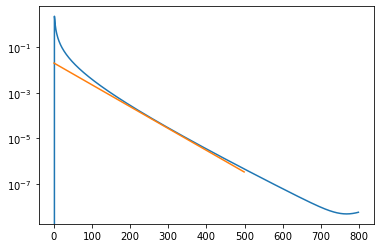

In [24]:
plt.plot( fftd.T[0] )

xx=np.arange(0, 500)
plt.plot( xx, 0.02*np.exp(-0.022*xx) )

plt.yscale("log")

In [25]:
1536/3

512.0

In [221]:
eps[:1024].T[2]

array([-9.50727003,  0.73667837,  0.2839783 , ...,  0.16014711,
        0.2839783 ,  1.78835694])

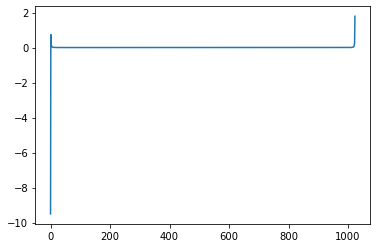

In [222]:
plt.plot( eps[:1024].T[2] )

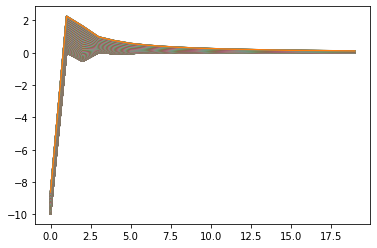

In [156]:
plt.plot(fftd.real)

In [135]:
t=1
tslice = retrieved[t].T[2]

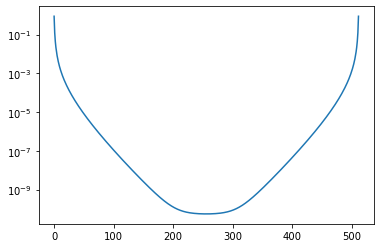

In [136]:
plt.plot(tslice)
plt.yscale("log")

In [113]:
tsliceF = np.fft.fft( tslice )

(0.01, 3.0)

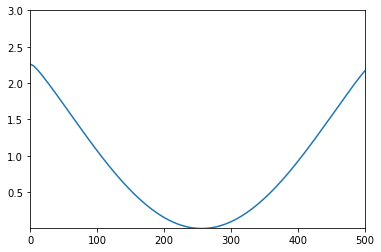

In [128]:
plt.plot( tsliceF.real )

# plt.yscale("log")
plt.xlim(0,500)
plt.ylim(0.01, 3)

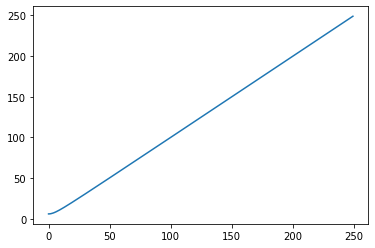

In [134]:
krange=np.arange(0,250)
m=6.0
tt=1

disp = np.sqrt( krange**2 + m**2 )
yyy=-0.5/disp * np.exp(-disp*tt)

plt.plot( krange, disp )

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [26]:
eps2d[0]

array([-9.50727003,  0.73667837,  0.2839783 , ...,  0.16014711,
        0.2839783 ,  1.78835694])

In [27]:
eps2d.T.shape

(1024, 1536)

In [28]:
toplot=np.array([ [np.sqrt(v[0]**2+v[1]**2)*0.01, v[2]] for v in eps ])

toplot2=np.array([ [np.sqrt(v[0]**2+v[1]**2)*0.01, v[2]] for v in eps2 ])

In [29]:
xx = np.linspace(0, 1, 101)

In [30]:
xx

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [31]:
alat=0.01

In [32]:
eps.shape

(1572864, 4)

In [33]:
1/alat

100.0

(0.0, 10.0)

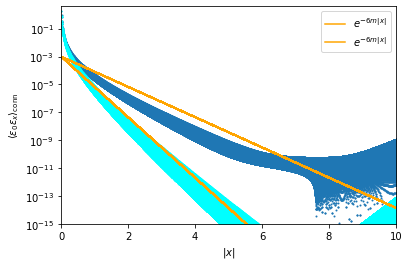

In [34]:
# plt.plot( xx, eps2d[0], label="y=0" )
# plt.plot( xx, eps2d.T[0], label="x=0" )

plt.scatter( toplot.T[0], toplot.T[1], s=1 )
plt.scatter( toplot2.T[0], toplot2.T[1], s=1, c="cyan" )
# plt.plot( xx, np.exp(-xx), label="$1/r^2$" )
plt.plot( toplot.T[0], 0.001*np.exp(-2.5*toplot.T[0]), label="$e^{-6m|x|}$", c="orange" )
plt.plot( toplot.T[0], 0.001*np.exp(-5*toplot.T[0]), label="$e^{-6m|x|}$", c="orange" )

plt.legend()

plt.yscale("log")
# plt.xscale("log")

plt.xlabel("$|x|$")
plt.ylabel("$\\langle \\varepsilon_0 \\varepsilon_x\\rangle_{\\rm conn}$")

plt.ylim(1.0e-15, 4)
plt.xlim(0, 10)

# plt.savefig("../figs/eps_corr.pdf", bbox_inches="tight")

In [6]:
from mpl_toolkits import mplot3d

/var/folders/mg/t8fn6fpj4bj1f7zd8q4m_6p40000gn/T/ipykernel_6655/454102474.py:3: RuntimeWarning: invalid value encountered in log
  ax.scatter( eps.T[0], eps.T[1], np.log(eps.T[2]) )


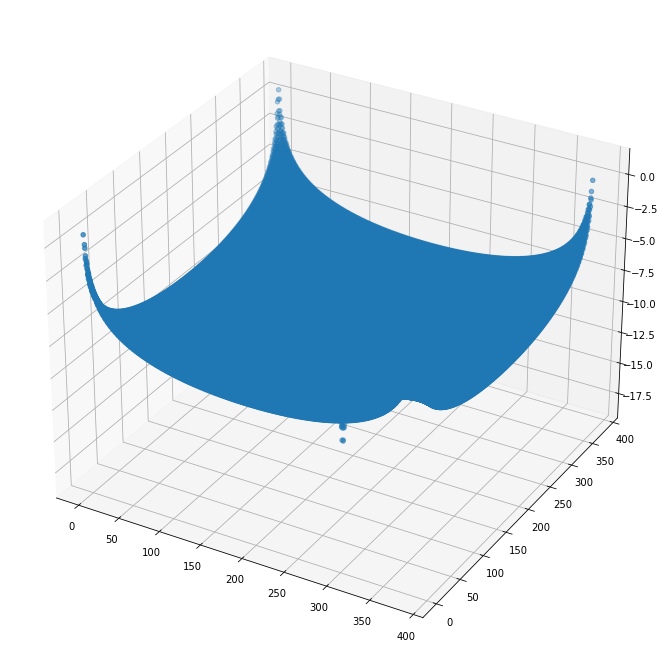

In [7]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter( eps.T[0], eps.T[1], np.log(eps.T[2]) )

# ax.set_yscale("log")

In [34]:
spec_m001 = np.loadtxt("spec_m001.dat")
spec_m1 = np.loadtxt("spec_m1.dat")
Lx = 36
Ly = 36

In [35]:
nvacant = int(Lx*Ly/3)
spec_nontriv_m1 = spec_m1[2*nvacant:]
spec_nontriv_m001 = spec_m001[2*nvacant:]

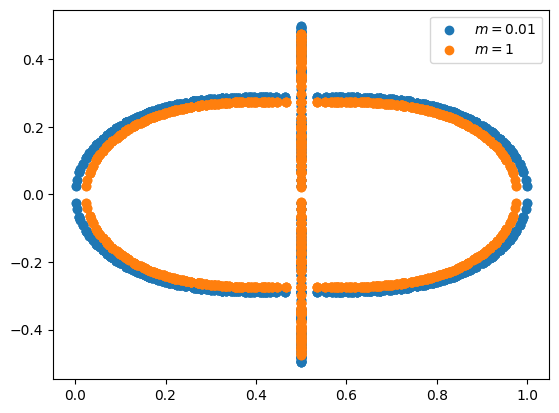

In [36]:
plt.scatter( spec_nontriv_m001.T[0], spec_nontriv_m001.T[1], label="$m=0.01$" )
plt.scatter( spec_nontriv_m1.T[0], spec_nontriv_m1.T[1], label="$m=1$")
plt.legend()

plt.savefig("spectrum.pdf", bbox_inches='tight')

In [ ]:
Lx = 36
Ly = 36

In [37]:
dinv0 = np.loadtxt("Dinv0.dat")
dinv1 = np.loadtxt("Dinv1.dat")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x84 in position 3: invalid start byte

In [60]:
y0psipsi=np.loadtxt("y0_psipsi.dat")
alat=0.01

In [61]:
xx=y0psipsi.T[0]*alat

/tmp/ipykernel_273721/2249424689.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot( xx, 0.000001/xx**3 )


(1e-10, 1.0)

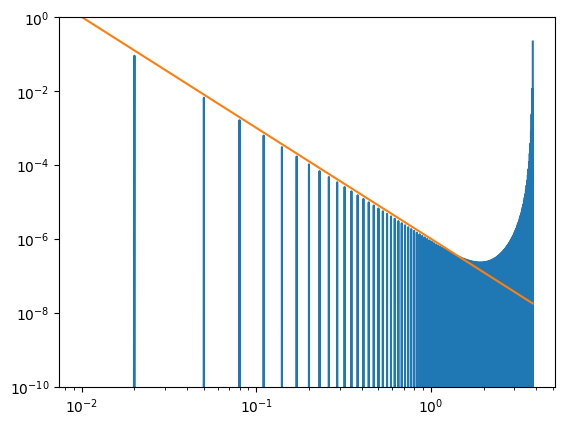

In [74]:
plt.plot( xx, y0psipsi.T[1] )
plt.yscale("log")
plt.xscale("log")

plt.plot( xx, 0.000001/xx**3 )

plt.ylim(1.0e-10, 1.0)

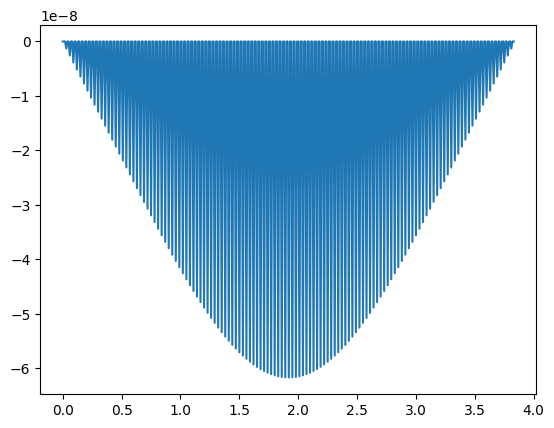

In [75]:
plt.plot( xx, y0psipsi.T[2] )

/tmp/ipykernel_273721/51402980.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot( xx, 0.008/xx**1.0 )


(0.001, 1.0)

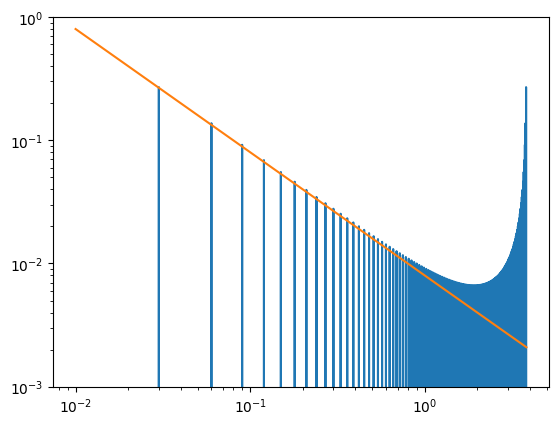

In [89]:
plt.plot( xx, y0psipsi.T[3] )
plt.yscale("log")
plt.xscale("log")

plt.plot( xx, 0.008/xx**1.0 )

plt.ylim(1.0e-3, 1.0)

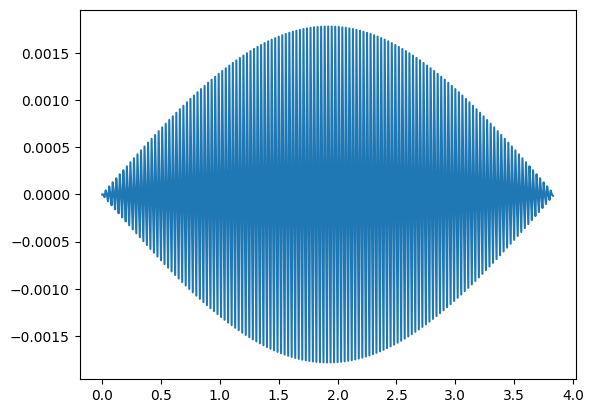

In [83]:
plt.plot( xx, y0psipsi.T[4] )